In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from scipy.interpolate import interp1d

from os import walk, path

from sklearn.metrics import roc_curve, auc

In [2]:
plt.rcParams.update({'font.family': 'cmr10',
                     'font.size': 12,
                     'axes.unicode_minus': False,
                     'axes.labelsize': 12,
                     'axes.labelsize': 12,
                     'figure.figsize': (4, 4),
                     'figure.dpi': 80,
                     'mathtext.fontset': 'cm',
                     'mathtext.rm': 'serif',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.top': True,
                     'ytick.right': True
                     })

# Load Data Files
## Adam Leinweber - Traditional VAE

In [3]:
AL = pd.read_csv('../data/all_csv/Adam_Leinweber_latent_combined_scores_all.csv',
            names=['Signal', 'Model', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']
           )

## Pratik Jawahar - Normalizing Flows

In [4]:
PJ = pd.read_csv('../data/all_csv/VAEwNormFlows_Results.csv',
                 names=['Signal', 'Model', 'AUC', '1e-2', '1e-3', '1e-4']
           )
snames = list(PJ['Signal'])
chan = [s.split('/')[0].replace('chan', '').replace('_sig', '') for s in snames]
snames = [s.split('/')[-1] for s in snames]

snames = ['_'.join(s.split('_')[:-1]) for s in snames]
PJ['Signal'] = snames
PJ['Chan'] = chan

## Alessandro Morandini - Density based models

In [5]:
AM = pd.read_csv('../data/all_csv/DE_scores.csv',
                 names=['Signal', 'Model', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']
                )

## Luc Hendrix - VAE_AUC

In [6]:
LH_VAE = pd.read_csv('../data/all_csv/vae_auc_scores.csv',
                     names=['Signal', 'Modelt', 'Metric', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']
                    )
LH_VAE['Model'] = LH_VAE['Modelt'] + '_' + LH_VAE['Metric']

## Luc Hendrix - Flow

In [7]:
LH_Flow = pd.read_csv('../data/all_csv/flow_auc_scores.csv',
                     names=['Signal', 'Modelt', 'Metric', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']
                    )
LH_Flow['Model'] = LH_Flow['Modelt'] + '_' + LH_Flow['Metric']

## Luc Hendrix - Combined

In [8]:
LH_Combined = pd.read_csv('../data/all_csv/combined_scores.csv',
                     names=['Signal', 'Modelt', 'Metric', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']
                    )
LH_Combined['Model'] = LH_Combined['Modelt'] + '_' + LH_Combined['Metric']

## Luc Hendrix - Fixed Target

In [9]:
LH_Fixed = pd.read_csv('../data/all_csv/results-fixed-target.csv',
                     names=['Signal', 'Modelt', 'Metric', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']
                    )
LH_Fixed['Model'] = LH_Fixed['Modelt'] + '_' + LH_Fixed['Metric']

In [10]:
LH_Fixed['Model'].unique().shape

(80,)

## Bryan Ostdiek - Deep Sets

In [11]:
BO = pd.read_csv('../data/all_csv/DeepSetsVAE_8d_results_combined.csv')
snames = list(BO['Signal'])
chan = [s.split('_')[-1].replace('chan', '') for s in snames]
sig = ['_'.join(s.split('_')[:-1]) for s in snames]
BO['Signal'] = sig
BO['Chan'] = chan
BO['Model'] = BO['ModelName']
BO['1e-2'] = BO['S1e-2']
BO['1e-3'] = BO['S1e-3']
BO['1e-4'] = BO['S1e-4']

## Combine All Submissions

In [12]:
names = ['Signal', 'Model', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']
AllCombined = np.array(AL[names])
AllCombined = np.vstack([AllCombined, PJ[names]])
AllCombined = np.vstack([AllCombined, AM[names]])
AllCombined = np.vstack([AllCombined, LH_VAE[names]])
AllCombined = np.vstack([AllCombined, LH_Flow[names]])
AllCombined = np.vstack([AllCombined, LH_Combined[names]])
AllCombined = np.vstack([AllCombined, LH_Fixed[names]])
AllCombined = np.vstack([AllCombined, BO[names]])
AllCombined = pd.DataFrame(AllCombined, columns=names)

In [13]:
AllCombined['Model'].unique().shape

(562,)

In [14]:
AllCombined[AllCombined['Chan'] == '3']['Model'].unique().shape

(554,)

In [15]:
for Chan in ['1', '2a', '2b', '3']:
    for mod in list(AllCombined['Model'].unique()):
        if mod not in list(AllCombined[AllCombined['Chan'] == Chan]['Model']):
            print(f'Missing Chan {Chan} for {mod}')

Missing Chan 3 for Fixed-combined-z377_MSE
Missing Chan 3 for Fixed-MSE0-z377_MSE
Missing Chan 3 for Fixed-MSE1-z377_MSE
Missing Chan 3 for Fixed-MSE2-z377_MSE
Missing Chan 3 for Fixed-MSE3-z377_MSE
Missing Chan 3 for Fixed-MSE4-z377_MSE
Missing Chan 3 for Fixed-MSE10-z377_MSE
Missing Chan 3 for Fixed-MSE25-z377_MSE


# Build Analysis Function
It is not obvious what the best metric is to use for quantifying which model performs the best. This will examine the area under the ROC curve (AUC), and the signal efficiency at three different background efficiencies $\epsilon_{s}\big(\epsilon_b = 10^{-2(-3)[-4]}\big)$. For each metric, we will then find the model which has the highest score for each signal, the models which have the top 5 scores for each signal, the average rank, the average score, and the minimum score.

In [16]:
def Analyze(CombinedDataFrame, Chan, Metric, MetricNumberDict, Plot):
    """
    Inputs:
        CombineedDataFrame: Pandas dataframe with columns ['Model', 'Signal', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']
        Chan: String with which signal chanel is being analyzed. Must be one of ['1', '2a', '2b', '3', 'All']
        Metric: String indicating the metric to use, must be one of ['AUC', '1e-2', '1e-3', '1e-4']
        MetricNumberDict: The number of models to include for each sorting. Will usually include 5, 
            but some of the rankings need different numbers.
            example: MetricNumberDict = {'top1': 5, 
                                         'top5': 5,
                                         'AverageRank': 5,
                                         'MeanScore': 5,
                                         'MedianScore': 5,
                                         'MinScore': 5}
        Plot: Boolean if to make bar plots or not
        
    """
    for col in ['Model', 'Signal', 'Chan', 'AUC', '1e-2', '1e-3', '1e-4']:
        if col not in CombinedDataFrame.columns:
            print(f'CombinedDataFrame is missing column {col}')
            return 0
    if Chan not in ['1', '2a', '2b', '3', 'All']:
        print(f'Invalid "Chan" selection: {Chan}')
        return 0
    if Metric not in ['AUC', '1e-2', '1e-3', '1e-4']:
        print(f'Invalid "Metric" selection: {Metric}')
        return 0
    
    if Chan != 'All':
        AnalyzeFrame = CombinedDataFrame[CombinedDataFrame['Chan'] == Chan]
    else:
        AnalyzeFrame = CombinedDataFrame
    
    # This helper variable combines the channel and signal since some signals appear in multiple channels
    chansig = AnalyzeFrame['Chan'] + '/' + AnalyzeFrame['Signal']
    chansig = np.unique(chansig)
    sigs = AnalyzeFrame.Signal.unique()
    mods = AnalyzeFrame.Model.unique()
    SortedScores = pd.DataFrame()
    SortedScores['Model'] = mods
    
    # Go through each of the signals to find the ranking of the models
    for sig in chansig:
        chan, sig = sig.split('/')
#         print(chan, sig)
        cs = AnalyzeFrame[(AnalyzeFrame['Signal'] == sig) & (AnalyzeFrame['Chan']==chan)]
        scorelist = cs[Metric]
        score_ranking = np.zeros_like(scorelist)
        for i, score in enumerate(np.argsort(-scorelist)):  # argsort gives the ordering to sort them, we want the orthogonal information
#             if len(scorelist) != 562:
#             print(i, score, cs.iloc[i])
            score_ranking[score] = i
#         print(score_ranking)
        SortedScores[sig] = score_ranking
    SortedScores['AverageRank'] = SortedScores[[col for col in SortedScores.columns if 'Model' not in col]].mean(axis=1)
#     print(SortedScores['AverageRank'])
    SortedScores['top1'] = (SortedScores[[col for col in SortedScores.columns if (('AverageRank' not in col)
                                                                                  and ('Model' not in col)
                                                                                 )]] < 1).sum(axis=1)
    SortedScores['top5'] = (SortedScores[[col for col in SortedScores.columns if (('AverageRank' not in col) and 
                                                                                  ('top1' not in col) and
                                                                                  ('Model' not in col)
                                                                                 )]] < 5).sum(axis=1)

    meanscore = []
    medianscore = []
    minscore = []
    for m in mods:
        tmpdf = AnalyzeFrame[AnalyzeFrame['Model'] == m]
        tmpscores = tmpdf[Metric]
        meanscore.append(tmpscores.mean())
        medianscore.append(tmpscores.median())
        minscore.append(tmpscores.min())
    SortedScores['MeanScore'] = meanscore
    SortedScores['MedianScore'] = medianscore
    SortedScores['MinScore'] = minscore
    
    BestC = []
    TopDict = {}

    for key in ['top1', 'top5', 'AverageRank', 'MeanScore', 'MedianScore', 'MinScore']:
        num = MetricNumberDict[key]
        if num == 0: continue
        TopDict[key] = SortedScores.sort_values(by=key,ascending=True if key =='AverageRank' else False)[['Model']][:num].to_numpy().reshape(num)
        BestC += list(TopDict[key])
        print('*'*40)
        print(f'Models from chan={Chan} ranked by metric={Metric} sorted by {key}')
        print(SortedScores.sort_values(by=key,ascending=True if key =='AverageRank' else False)[['Model', key]][:num])
        print('*'*40)
        print()
        
    if Plot:
        BestC = np.array(BestC).flatten()
        BestCU = np.unique(BestC)
        
        Criteria = [['Top score on a signal', TopDict['top1']],
                    ['Top 5 score on a signal', TopDict['top5']],
                    ['Average Rank', TopDict['AverageRank']],
                    ['Mean Score', TopDict['MeanScore']],
                    ['Median Score', TopDict['MedianScore']],
                    ['Minimum Score', TopDict['MinScore'] if MetricNumberDict['MinScore'] else []]
                   ]
        if MetricNumberDict['MinScore'] == 0:
            Criteria=Criteria[:-1]

        for (name, crit) in Criteria:
            plt.figure(figsize=(8, 5))
            colors = ['grey' if m not in crit else 'C0' for m in BestCU]

            for colnum, col in enumerate(['AUC', '1e-2', '1e-3', '1e-4']):
                ax = plt.subplot(1, 4, colnum + 1)
                if col == Metric:
                    ax.set_facecolor('lavenderblush')
                yvs=[]
                names = []
                data_all = []
                for i,m in enumerate(BestCU):
                    tmp_data = []
                    tmpdf = AnalyzeFrame[AnalyzeFrame['Model']==m].copy()
                    for s in chansig:
                        chan, s = s.split('/')
                        tmpauc = tmpdf[(tmpdf['Signal'] == s) & (tmpdf['Chan']==chan)][col]
#                         if tmpauc.empty:
#                             print(s, m, 'Empty')
#                             tmpauc[col]=0
                        tmp_data.append(tmpauc)
                    data_all.append(np.array(tmp_data).reshape(len(chansig)))
                    yvs.append(i)
                    names.append(m)
                databp = np.array(data_all).reshape(len(BestCU), len(chansig))
                databp[databp == 0] = 1e-10
                bbox1 = plt.boxplot(databp.T,
                            vert=False,
                            manage_ticks=False,
                            patch_artist=True,
                            medianprops={'color':'k'},
                            positions=yvs
                           )

        #         for i, yv in enumerate(yvs):
        #             if colnum == 1:
        #                 plt.text(np.min(databp[i])*.95, yv, f'mean: {np.mean(databp[i]):1.2e}',
        #                      ha='right',
        #                      va='center'
        #                     )

                if colnum == 0:
                    plt.yticks(yvs, [n.replace('_', r'$\_$') for n in names])
                    plt.xlim(0, 1)
                else:
                    plt.yticks(yvs, [])
                    plt.xscale('log')
                    plt.xlim(1e-4, 1)
                    plt.xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])


                for patch, color in zip(bbox1['boxes'], colors):
                    patch.set_facecolor(color)
                    plt.minorticks_on()
                plt.grid()
                plt.xlabel(col)

            plt.suptitle(f'Best Models on Chan:{Chan} based on {Metric}: {name}')
            plt.savefig(f'../reports/Plots/TopChan{Chan}_{Metric}_{name.replace(" ", "_")}_boxplot.pdf', bbox_inches='tight')   

# Do the analysis
## Chan 1
### AUC

****************************************
Models from chan=1 ranked by metric=AUC sorted by top1
                                         Model  top1
477  Combined-AVG_VAE Radius + Flow Likelihood     4
294                      VAE_ConvolutionalFlow     2
482                     Fixed-combined-z34_MSE     1
536                        Fixed-MSE4-z233_MSE     1
****************************************

****************************************
Models from chan=1 ranked by metric=AUC sorted by top5
                                          Model  top5
477   Combined-AVG_VAE Radius + Flow Likelihood     5
476  Combined-PROD_VAE Radius + Flow Likelihood     5
532                          Fixed-MSE4-z34_MSE     3
475    Combined-OR_VAE Radius + Flow Likelihood     3
474   Combined-AND_VAE Radius + Flow Likelihood     3
294                       VAE_ConvolutionalFlow     3
****************************************

****************************************
Models from chan=1 ranked by metric=AUC 

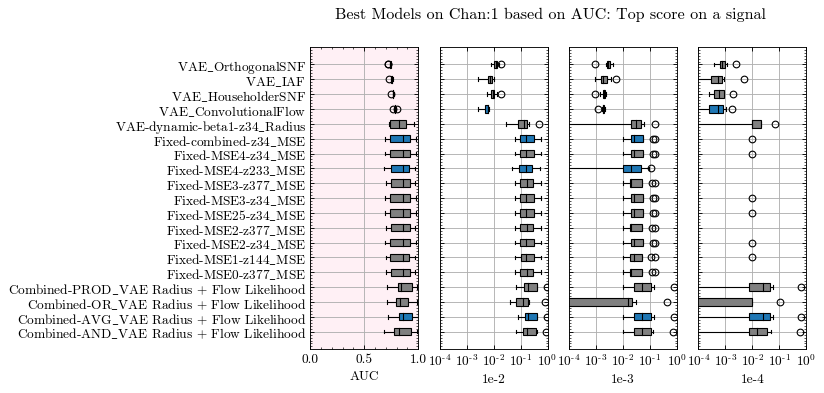

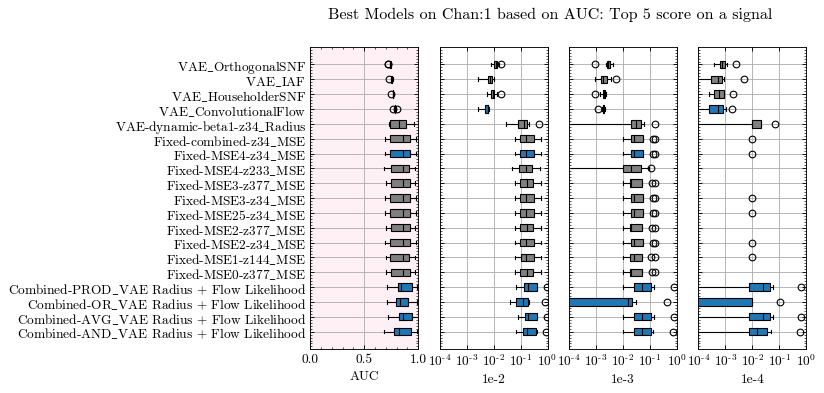

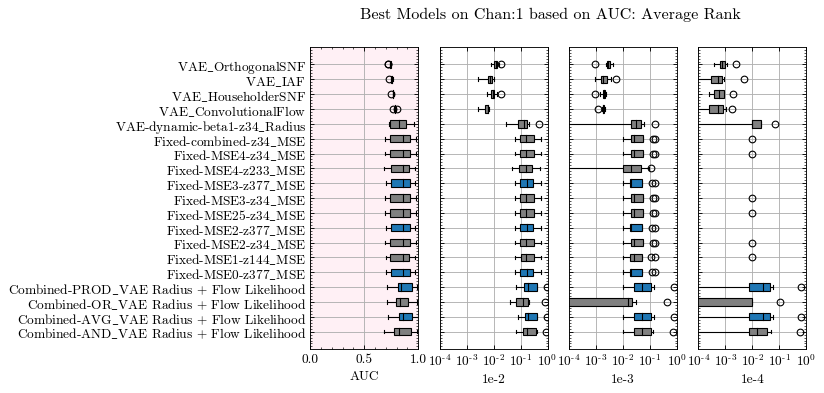

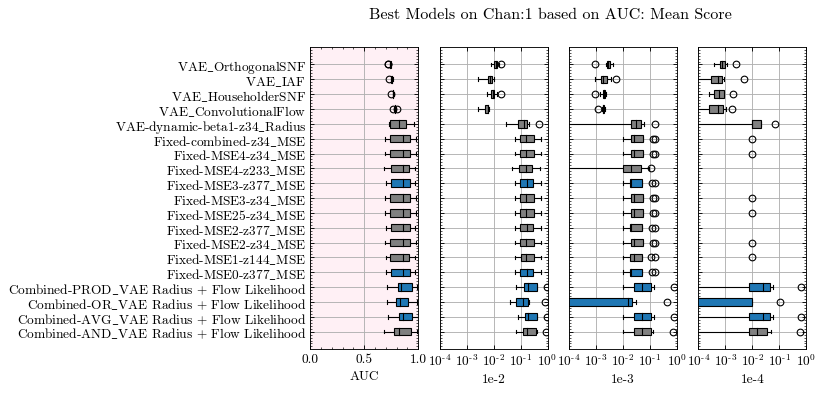

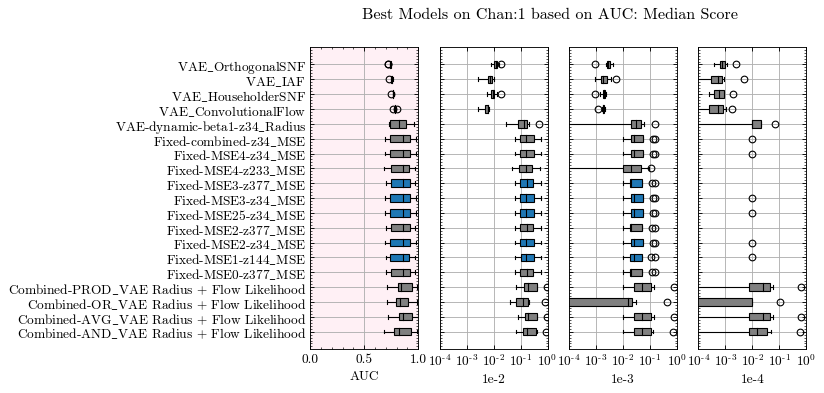

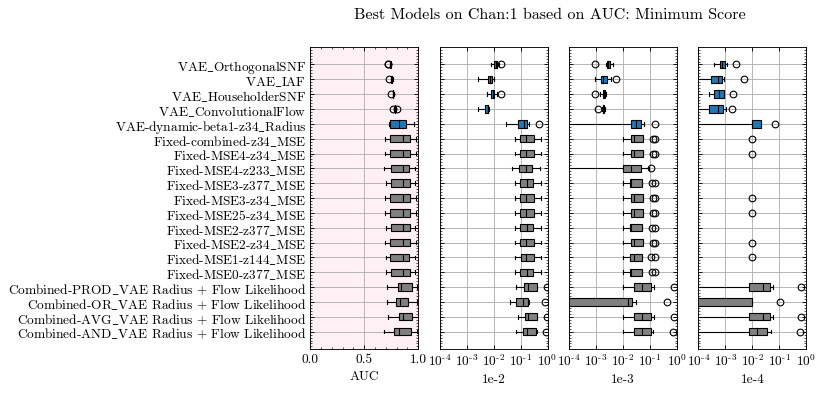

In [17]:
Analyze(AllCombined, 
        Chan='1', 
        Metric='AUC',
        MetricNumberDict = {'top1': 4,
                            'top5': 6,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )

### 1e-2

****************************************
Models from chan=1 ranked by metric=1e-2 sorted by top1
                                          Model  top1
303                                    PCA_D=10     2
476  Combined-PROD_VAE Radius + Flow Likelihood     2
477   Combined-AVG_VAE Radius + Flow Likelihood     2
525                         Fixed-MSE3-z144_MSE     1
495                         Fixed-MSE0-z144_MSE     1
****************************************

****************************************
Models from chan=1 ranked by metric=1e-2 sorted by top5
                                          Model  top5
477   Combined-AVG_VAE Radius + Flow Likelihood     4
476  Combined-PROD_VAE Radius + Flow Likelihood     4
474   Combined-AND_VAE Radius + Flow Likelihood     4
302                                     PCA_D=9     3
303                                    PCA_D=10     3
****************************************

****************************************
Models from chan=1 ranked by metr

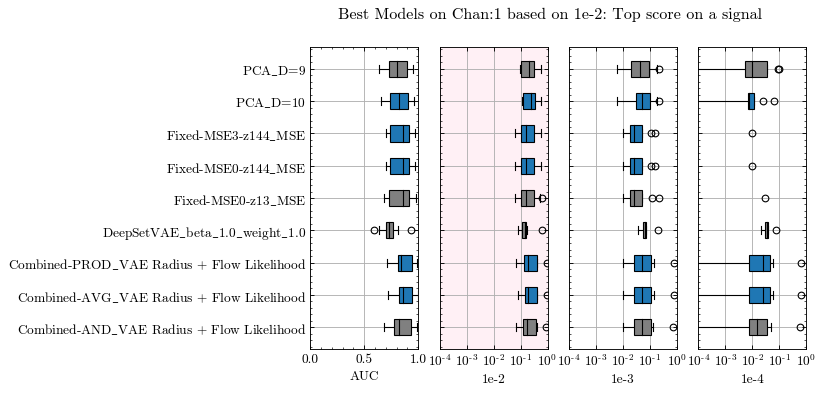

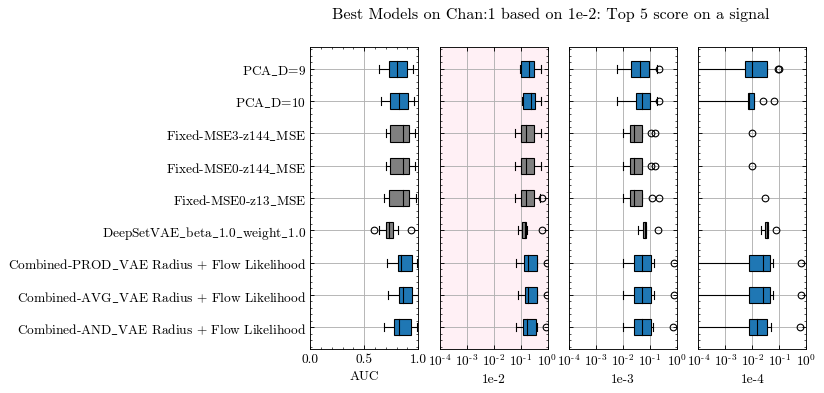

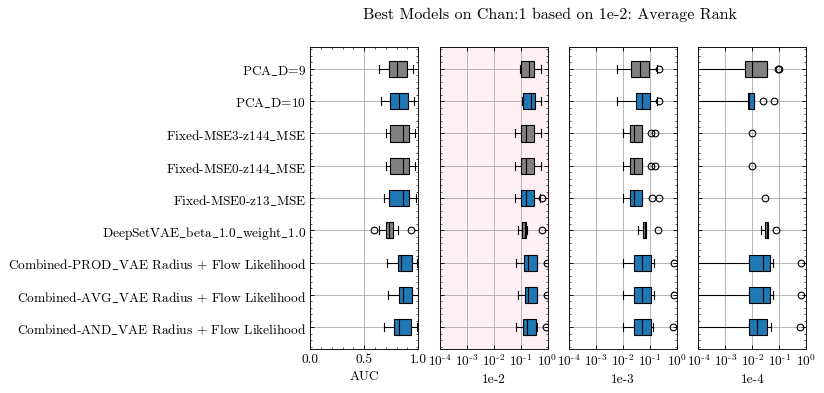

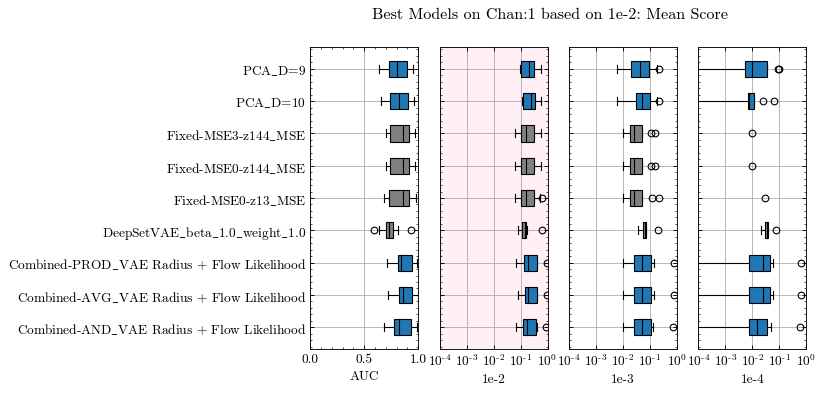

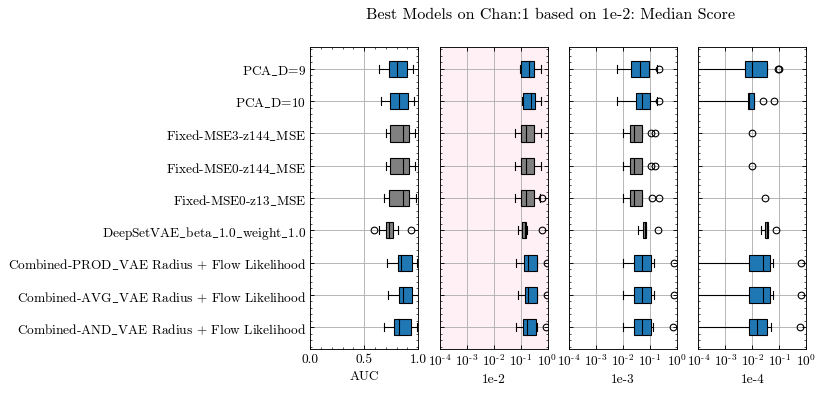

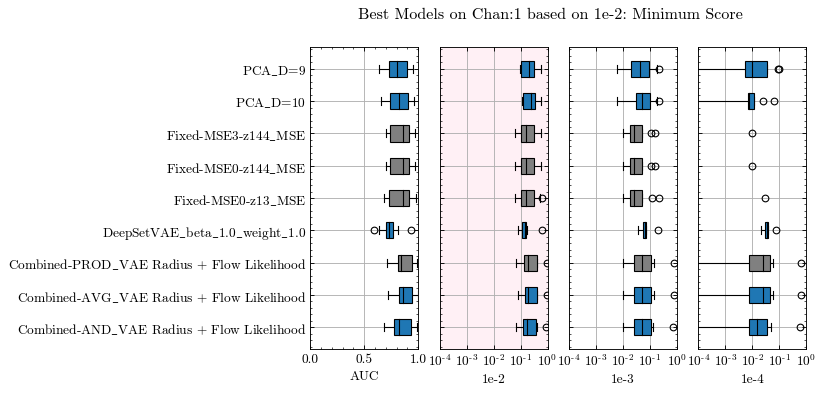

In [18]:
Analyze(AllCombined, 
        Chan='1', 
        Metric='1e-2',
        MetricNumberDict = {'top1': 5,
                            'top5': 5,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )

### 1e-3

****************************************
Models from chan=1 ranked by metric=1e-3 sorted by top1
                                          Model  top1
558              DeepSetVAE_beta_1.0_weight_1.0     3
446            VAE-dynamic-beta0.999-z21_Radius     1
477   Combined-AVG_VAE Radius + Flow Likelihood     1
303                                    PCA_D=10     1
476  Combined-PROD_VAE Radius + Flow Likelihood     1
302                                     PCA_D=9     1
****************************************

****************************************
Models from chan=1 ranked by metric=1e-3 sorted by top5
                                          Model  top5
558              DeepSetVAE_beta_1.0_weight_1.0     6
303                                    PCA_D=10     5
477   Combined-AVG_VAE Radius + Flow Likelihood     4
476  Combined-PROD_VAE Radius + Flow Likelihood     4
474   Combined-AND_VAE Radius + Flow Likelihood     4
302                                     PCA_D=9     3
446     

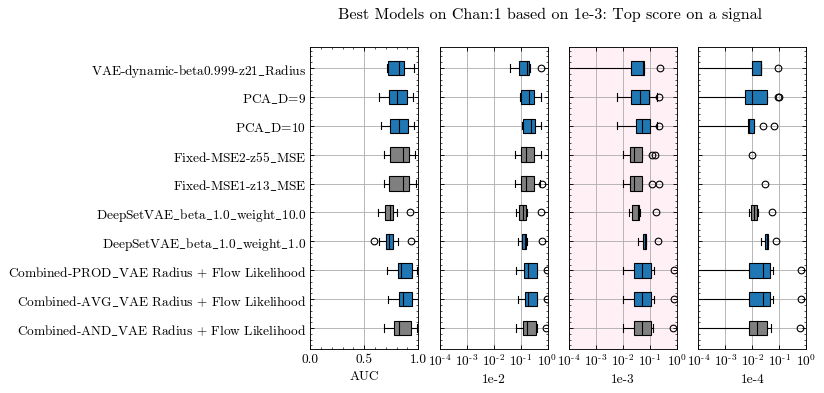

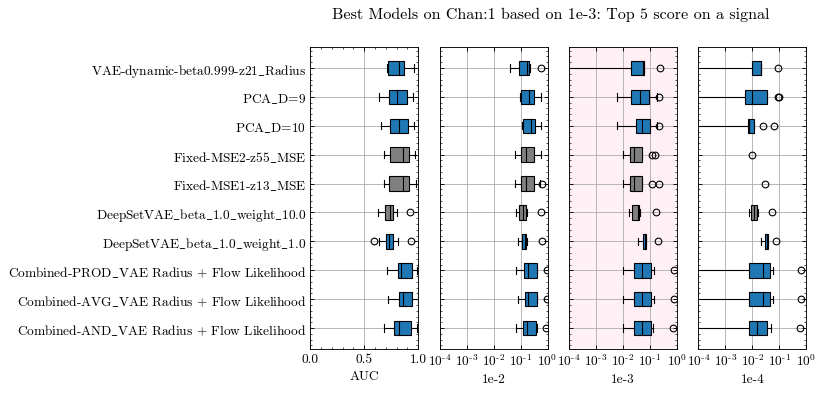

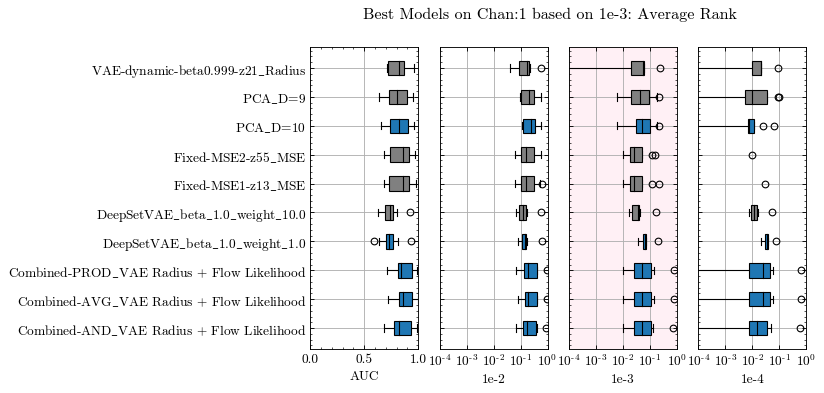

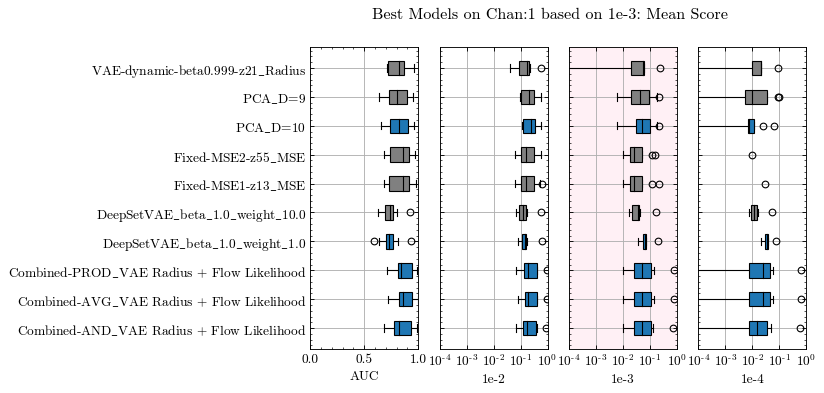

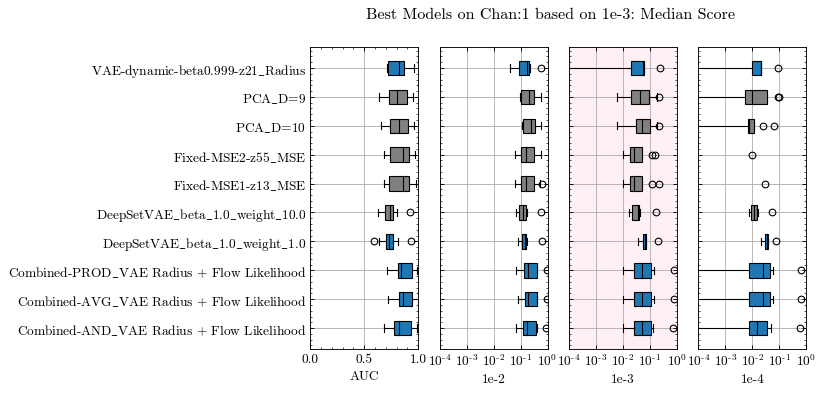

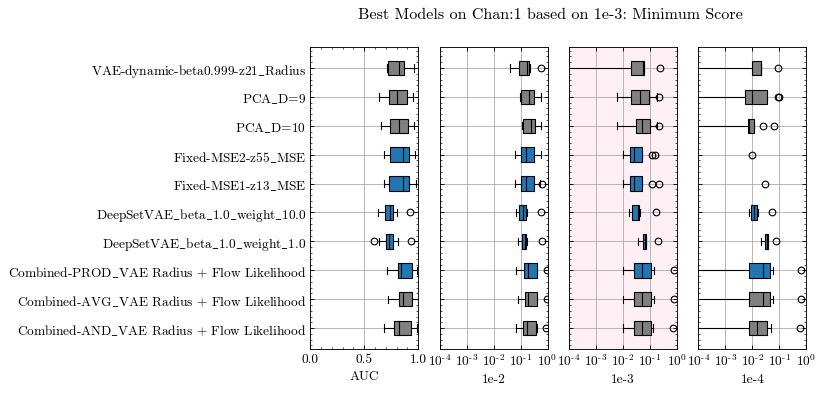

In [19]:
Analyze(AllCombined, 
        Chan='1', 
        Metric='1e-3',
        MetricNumberDict = {'top1': 6,
                            'top5': 7,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )

### 1e-4

****************************************
Models from chan=1 ranked by metric=1e-4 sorted by top1
                                          Model  top1
558              DeepSetVAE_beta_1.0_weight_1.0     5
302                                     PCA_D=9     1
476  Combined-PROD_VAE Radius + Flow Likelihood     1
477   Combined-AVG_VAE Radius + Flow Likelihood     1
****************************************

****************************************
Models from chan=1 ranked by metric=1e-4 sorted by top5
                                          Model  top5
558              DeepSetVAE_beta_1.0_weight_1.0     6
477   Combined-AVG_VAE Radius + Flow Likelihood     5
476  Combined-PROD_VAE Radius + Flow Likelihood     5
302                                     PCA_D=9     3
300                                     PCA_D=7     3
****************************************

****************************************
Models from chan=1 ranked by metric=1e-4 sorted by AverageRank
                        

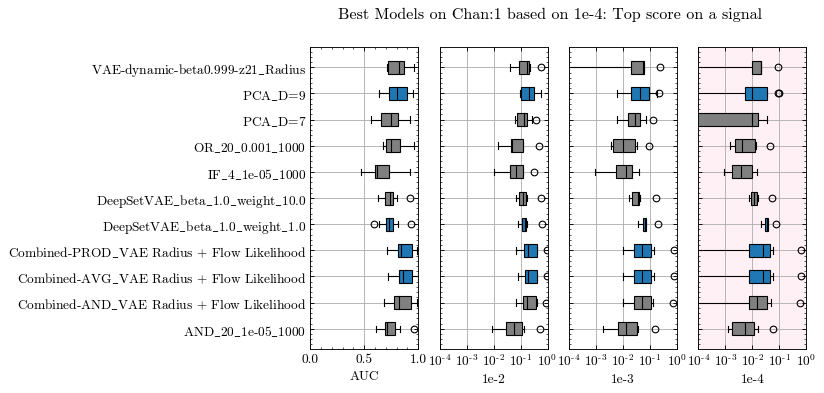

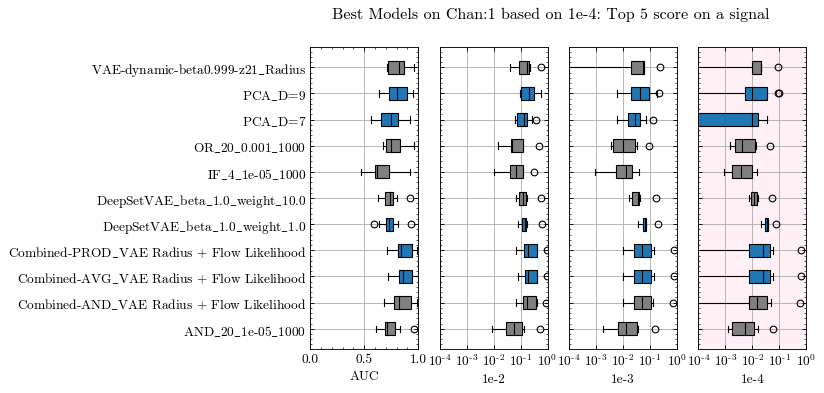

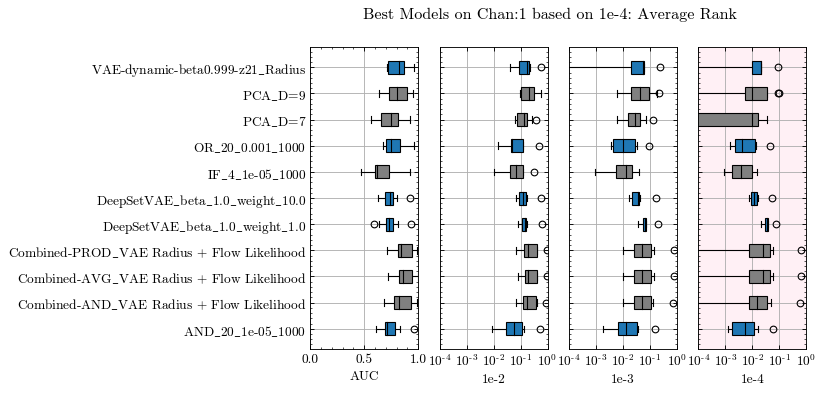

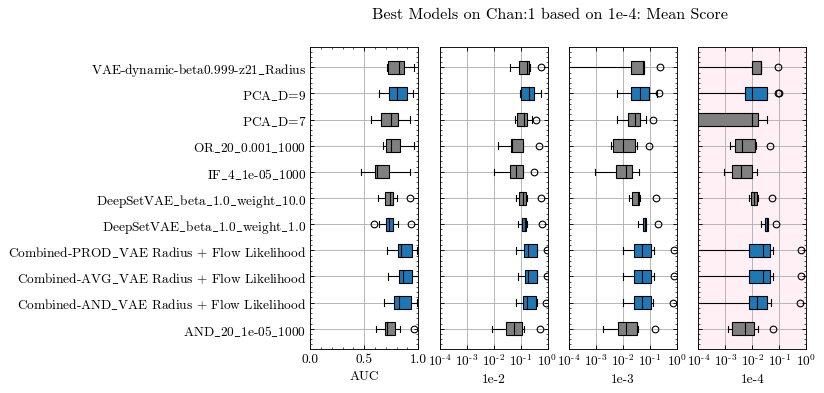

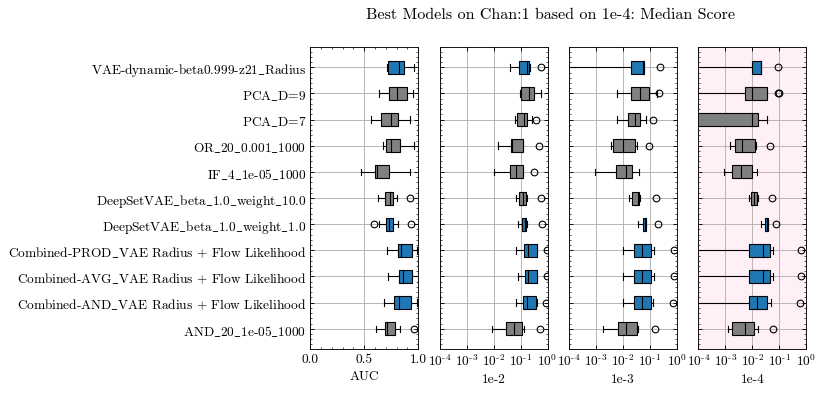

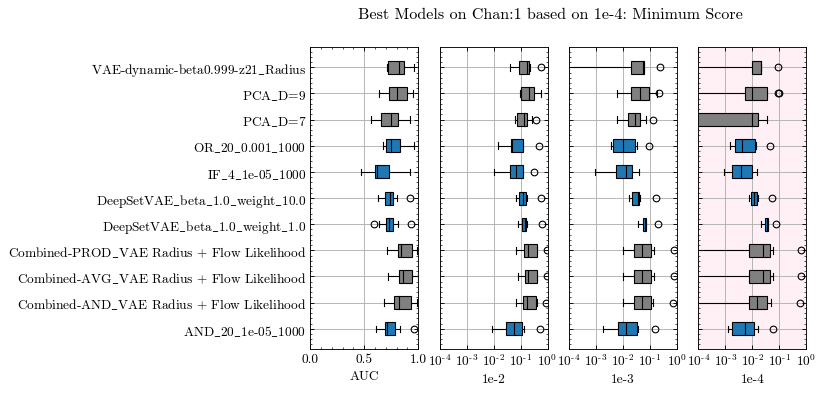

In [20]:
Analyze(AllCombined, 
        Chan='1', 
        Metric='1e-4',
        MetricNumberDict = {'top1': 4,
                            'top5': 5,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )

## Chan 2a
### AUC

****************************************
Models from chan=2a ranked by metric=AUC sorted by top1
                                          Model  top1
391                    VAE-static-beta0.5-z5_RL     2
291                           VAE_OrthogonalSNF     2
395                    VAE-static-beta0.5-z8_RL     1
476  Combined-PROD_VAE Radius + Flow Likelihood     1
312                             VAE_b=1e-5_D=10     1
****************************************

****************************************
Models from chan=2a ranked by metric=AUC sorted by top5
                 Model  top5
291  VAE_OrthogonalSNF     5
292  VAE_TriangularSNF     4
293            VAE_IAF     4
****************************************

****************************************
Models from chan=2a ranked by metric=AUC sorted by AverageRank
                 Model  AverageRank
210    AND_30_0.1_1000    69.571429
291  VAE_OrthogonalSNF    75.142857
216   AND_4_0.001_1000    75.571429
293            VAE_IAF    77.42857

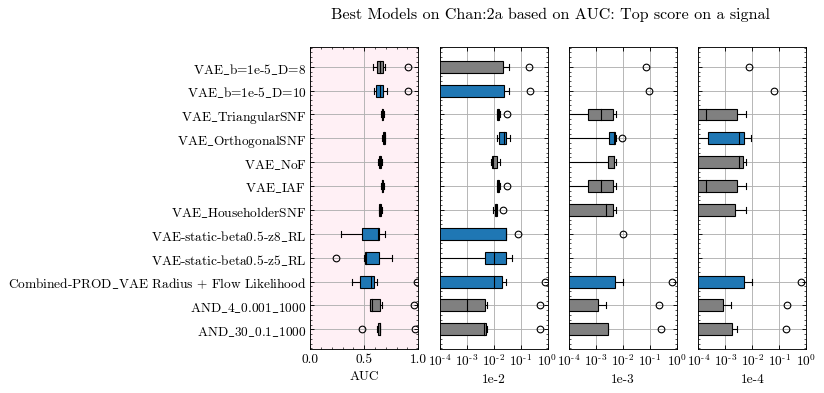

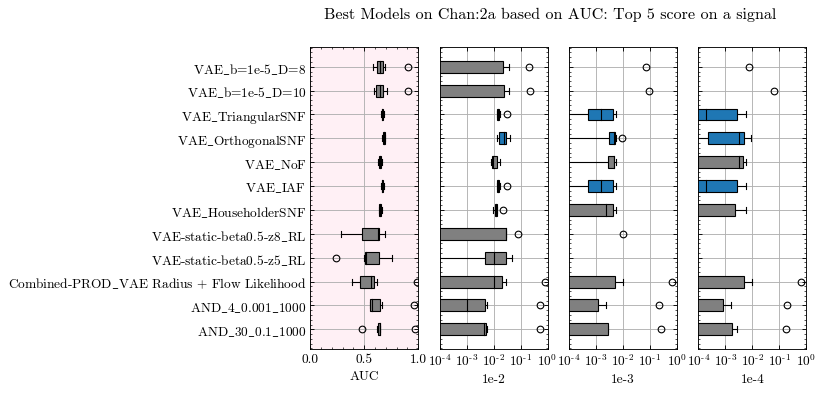

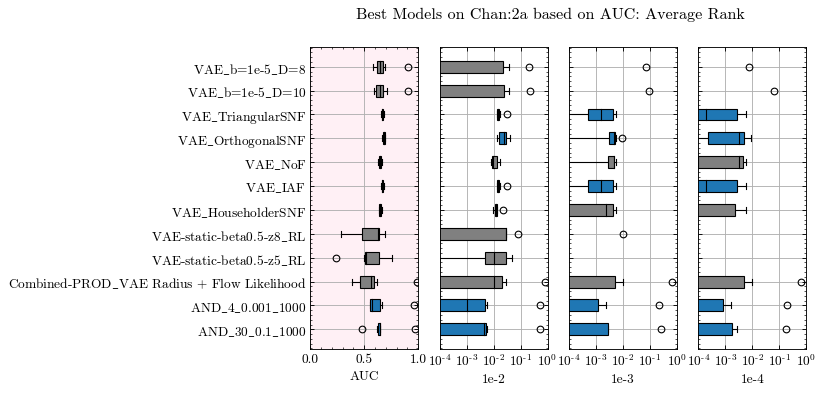

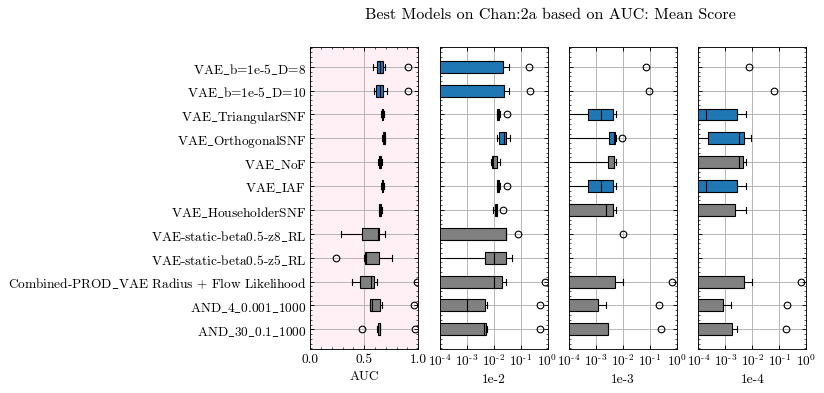

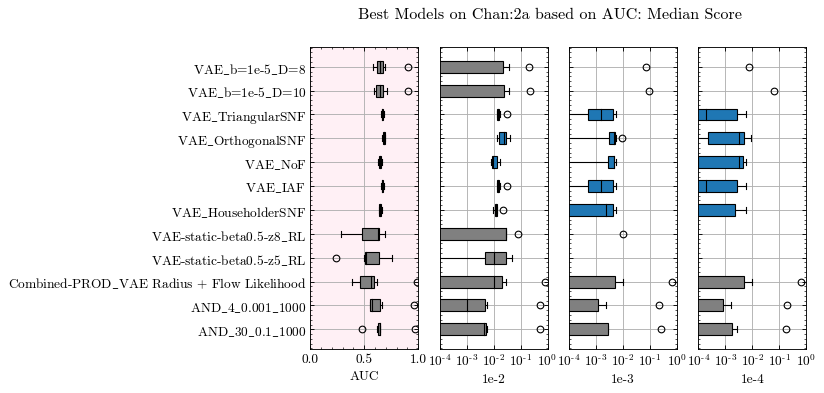

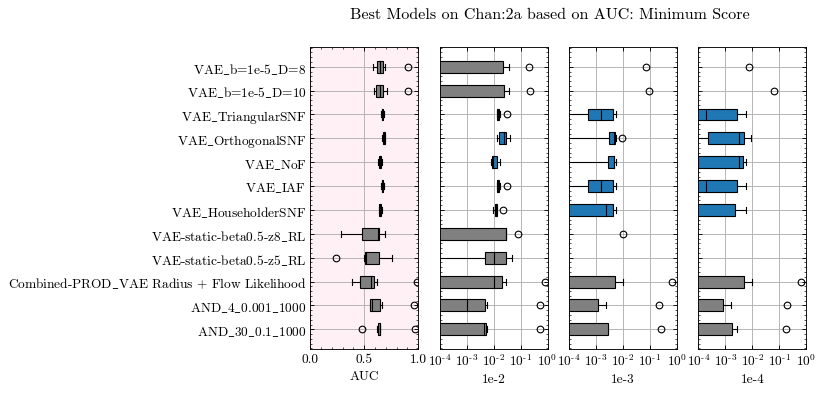

In [21]:
Analyze(AllCombined, 
        Chan='2a', 
        Metric='AUC',
        MetricNumberDict = {'top1': 5,
                            'top5': 3,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )

### 1e-2

****************************************
Models from chan=2a ranked by metric=1e-2 sorted by top1
                           Model  top1
527          Fixed-MSE3-z377_MSE     1
391     VAE-static-beta0.5-z5_RL     1
407    VAE-static-beta0.5-z34_RL     1
395     VAE-static-beta0.5-z8_RL     1
333  VAE-dynamic-beta1e-06-z5_RL     1
28                 IF_4_1.0_1000     1
524           Fixed-MSE3-z89_MSE     1
****************************************

****************************************
Models from chan=2a ranked by metric=1e-2 sorted by top5
                         Model  top5
28               IF_4_1.0_1000     2
391   VAE-static-beta0.5-z5_RL     2
407  VAE-static-beta0.5-z34_RL     2
****************************************

****************************************
Models from chan=2a ranked by metric=1e-2 sorted by AverageRank
                     Model  AverageRank
498      Fixed-MSE1-z5_MSE    69.428571
478  Fixed-combined-z5_MSE    71.000000
28           IF_4_1.0_1000    78.00

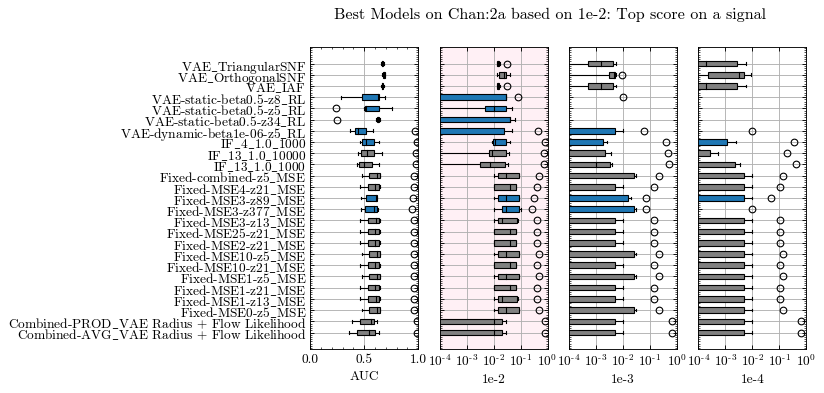

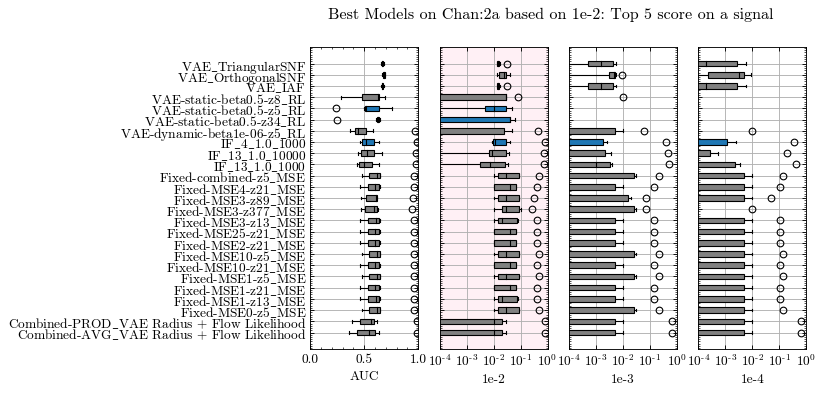

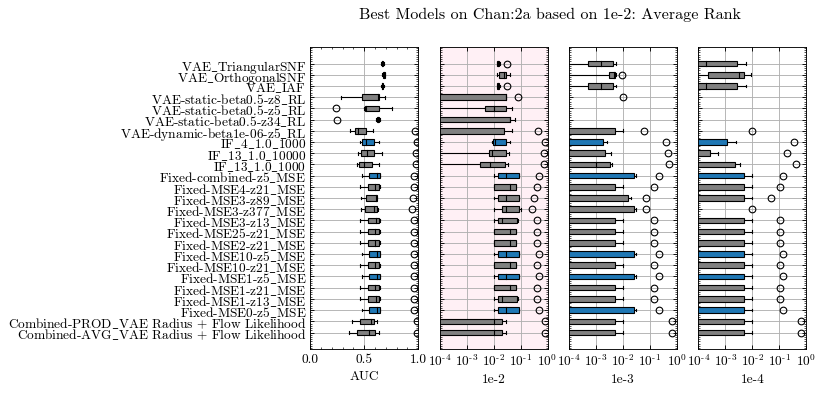

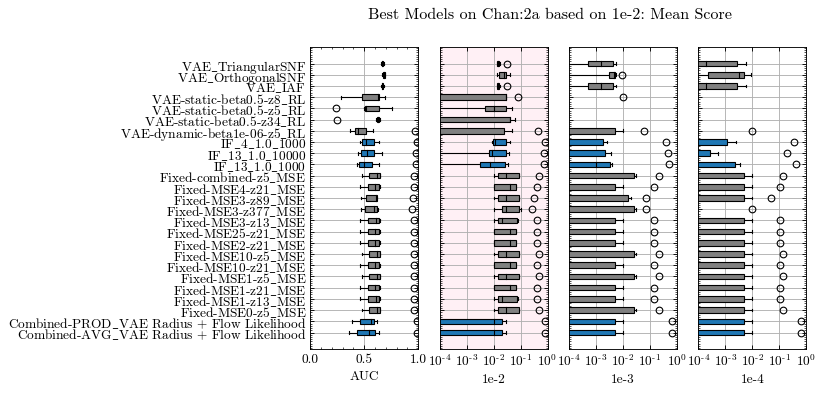

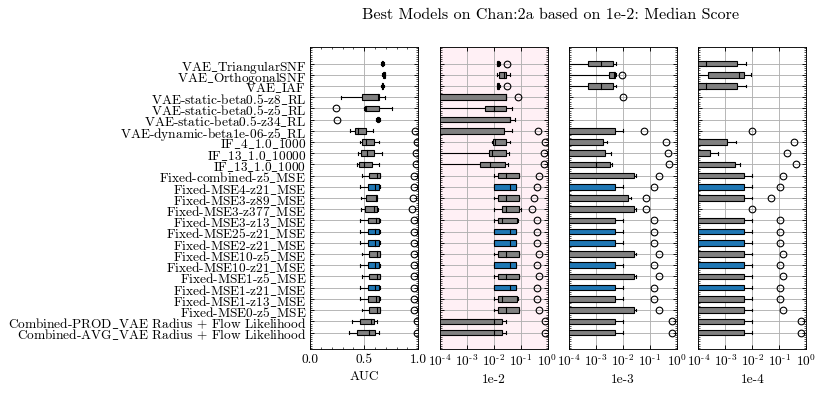

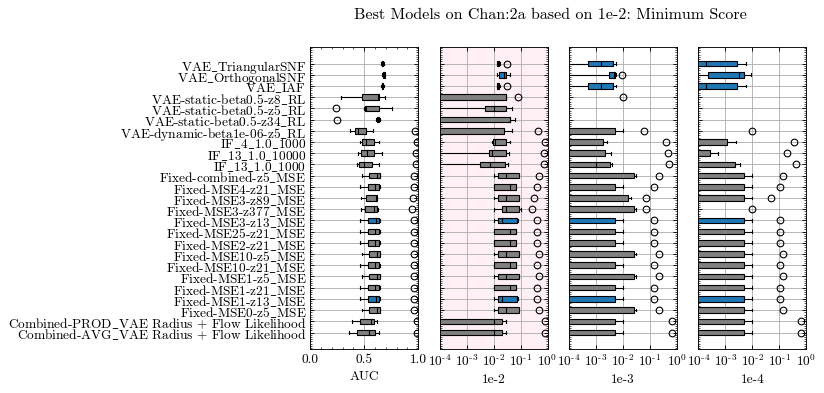

In [22]:
Analyze(AllCombined, 
        Chan='2a', 
        Metric='1e-2',
        MetricNumberDict = {'top1': 7,
                            'top5': 3,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )

### 1e-3

****************************************
Models from chan=2a ranked by metric=1e-3 sorted by top1
                                         Model  top1
488                          Fixed-MSE0-z5_MSE     1
492                         Fixed-MSE0-z34_MSE     1
387                  VAE-static-beta0.1-z34_RL     1
298                                    PCA_D=5     1
324                             VAE_b=1e-1_D=4     1
345               VAE-dynamic-beta1e-06-z21_RL     1
477  Combined-AVG_VAE Radius + Flow Likelihood     1
****************************************

****************************************
Models from chan=2a ranked by metric=1e-3 sorted by top5
                            Model  top5
291             VAE_OrthogonalSNF     2
289                VAE_PlanarFlow     2
345  VAE-dynamic-beta1e-06-z21_RL     2
488             Fixed-MSE0-z5_MSE     2
538            Fixed-MSE10-z5_MSE     2
537           Fixed-MSE4-z377_MSE     2
341  VAE-dynamic-beta1e-06-z13_RL     2
298               

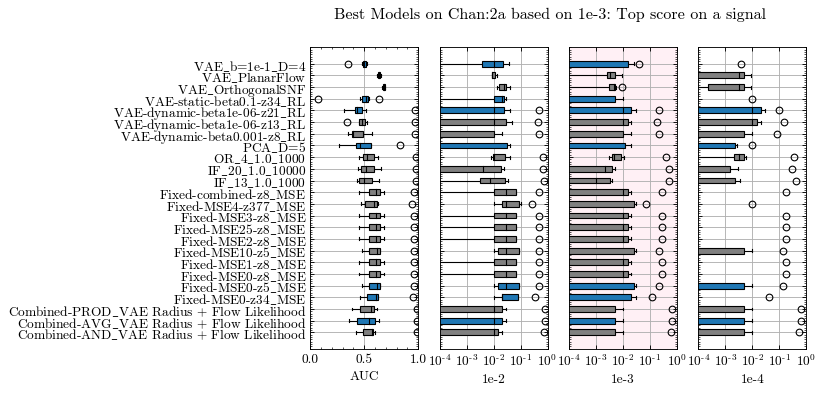

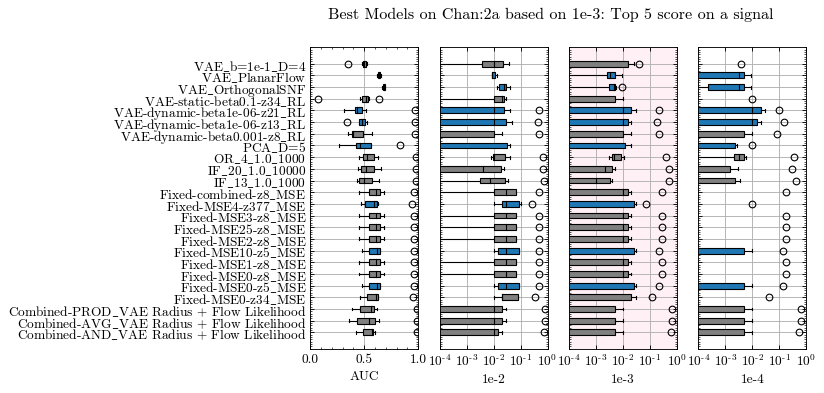

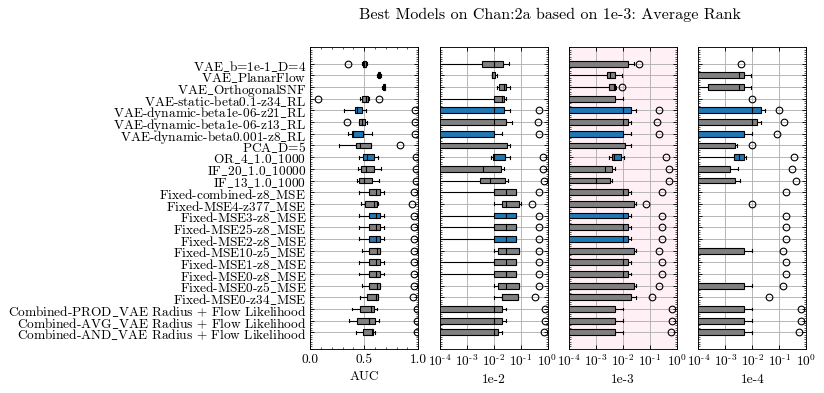

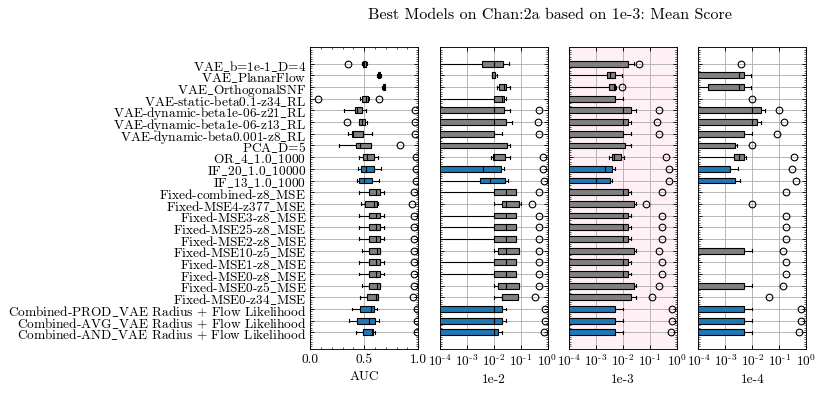

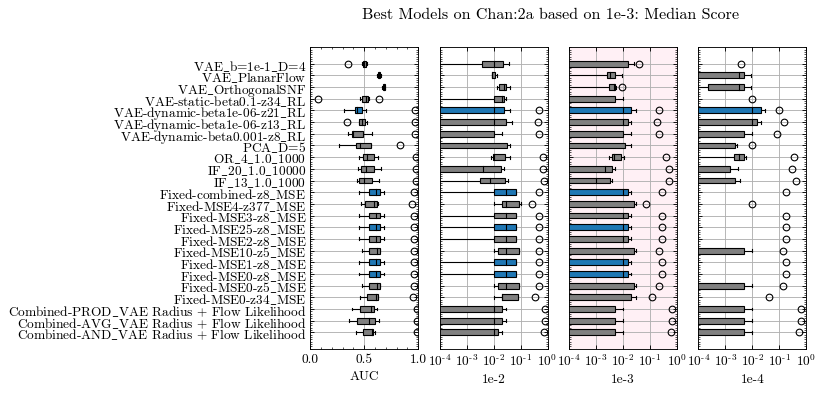

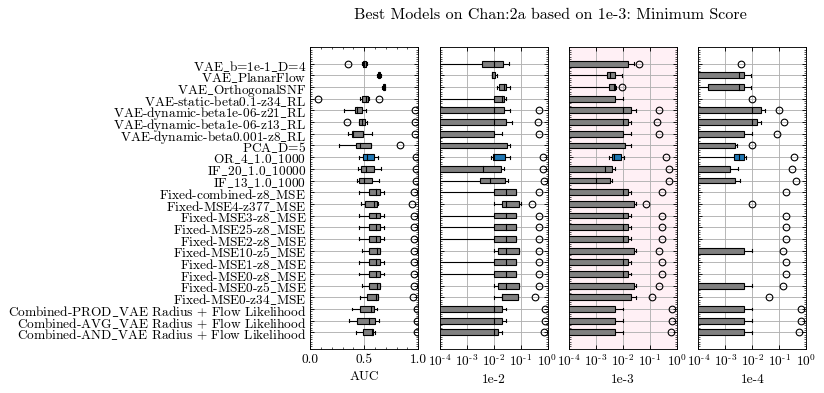

In [23]:
Analyze(AllCombined, 
        Chan='2a', 
        Metric='1e-3',
        MetricNumberDict = {'top1': 7,
                            'top5': 8,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 1},
        Plot=True
       )

### 1e-4

****************************************
Models from chan=2a ranked by metric=1e-4 sorted by top1
                                         Model  top1
387                  VAE-static-beta0.1-z34_RL     1
345               VAE-dynamic-beta1e-06-z21_RL     1
297                                    PCA_D=4     1
477  Combined-AVG_VAE Radius + Flow Likelihood     1
291                          VAE_OrthogonalSNF     1
439                VAE-static-beta0.999-z13_RL     1
494                         Fixed-MSE0-z89_MSE     1
****************************************

****************************************
Models from chan=2a ranked by metric=1e-4 sorted by top5
                                          Model  top5
288                                     VAE_NoF     3
289                              VAE_PlanarFlow     3
345                VAE-dynamic-beta1e-06-z21_RL     3
477   Combined-AVG_VAE Radius + Flow Likelihood     2
291                           VAE_OrthogonalSNF     2
476  Combined-

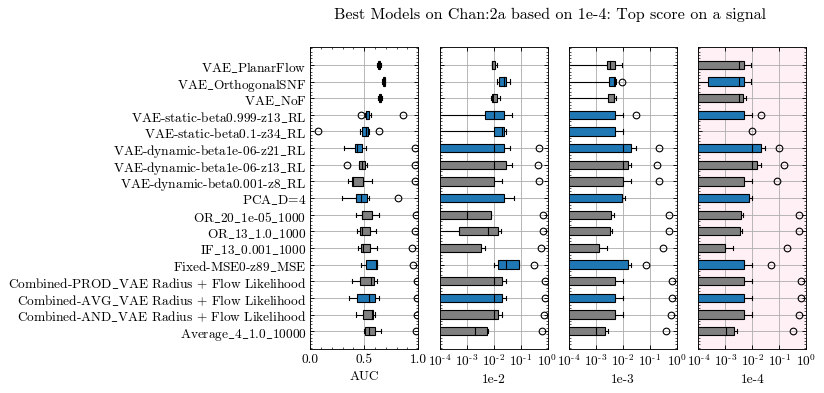

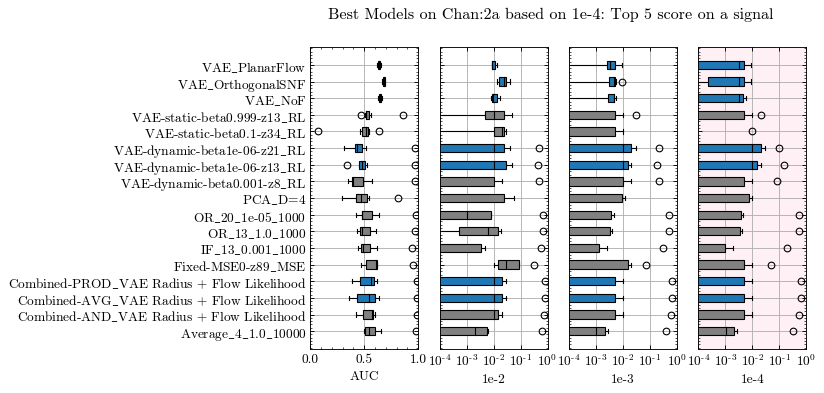

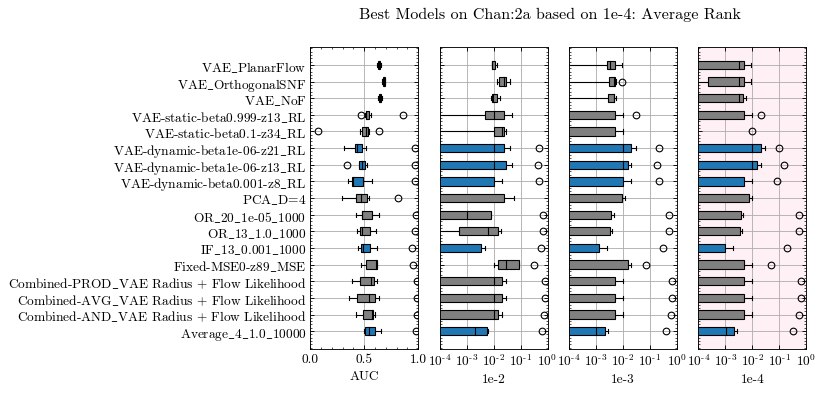

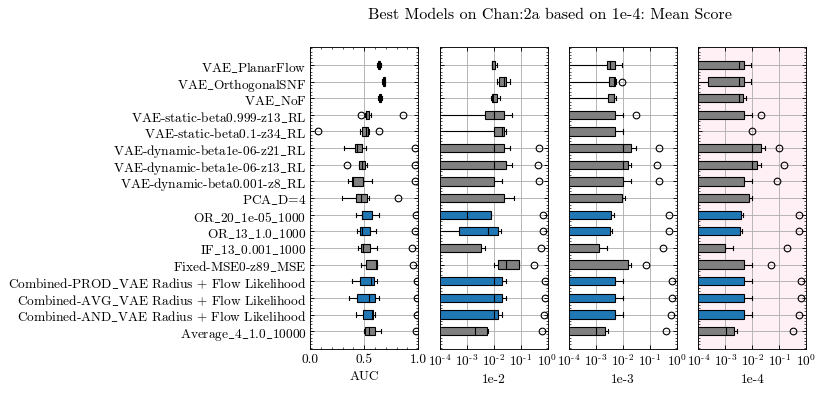

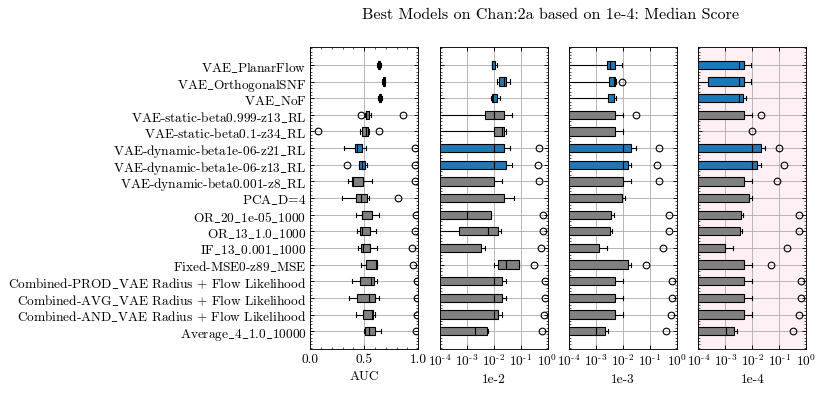

In [24]:
Analyze(AllCombined, 
        Chan='2a', 
        Metric='1e-4',
        MetricNumberDict = {'top1': 7,
                            'top5': 7,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 0},
        Plot=True
       )

## Chan 2b
### AUC

****************************************
Models from chan=2b ranked by metric=AUC sorted by top1
                                          Model  top1
291                           VAE_OrthogonalSNF     3
476  Combined-PROD_VAE Radius + Flow Likelihood     2
477   Combined-AVG_VAE Radius + Flow Likelihood     2
475    Combined-OR_VAE Radius + Flow Likelihood     1
494                          Fixed-MSE0-z89_MSE     1
****************************************

****************************************
Models from chan=2b ranked by metric=AUC sorted by top5
                                          Model  top5
474   Combined-AND_VAE Radius + Flow Likelihood     5
477   Combined-AVG_VAE Radius + Flow Likelihood     5
476  Combined-PROD_VAE Radius + Flow Likelihood     5
291                           VAE_OrthogonalSNF     5
472              Flow-Efficient-No-E_Likelihood     4
475    Combined-OR_VAE Radius + Flow Likelihood     4
292                           VAE_TriangularSNF     4
293     

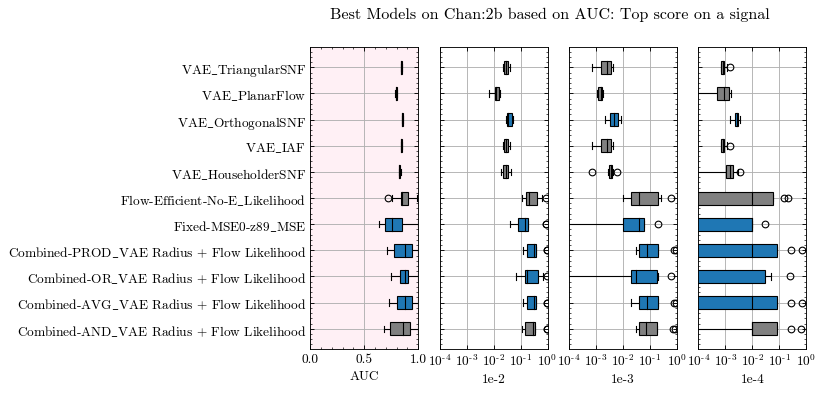

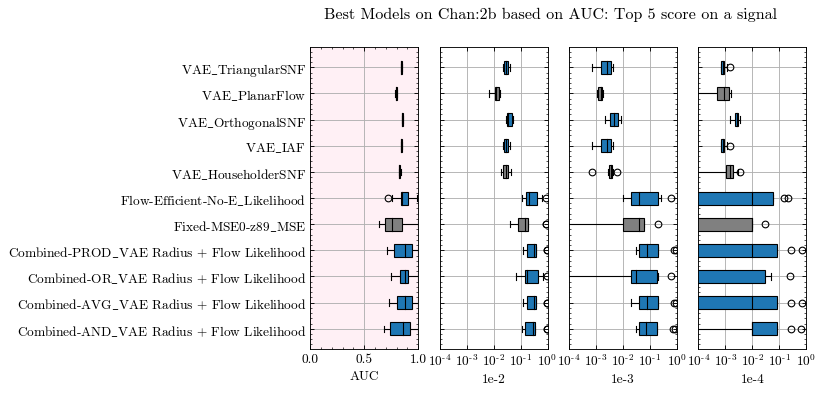

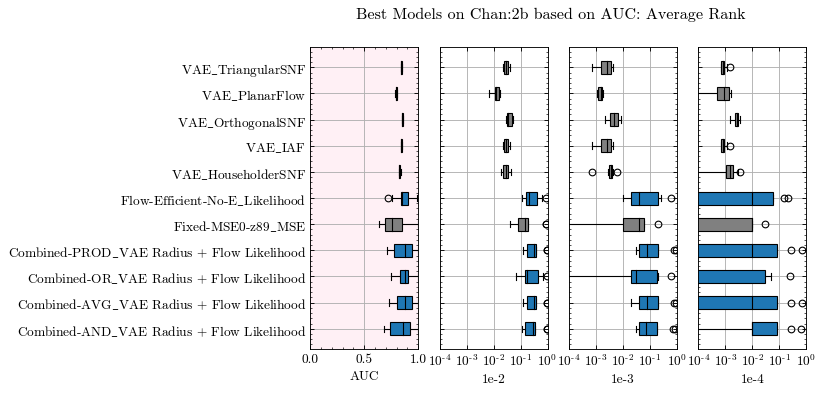

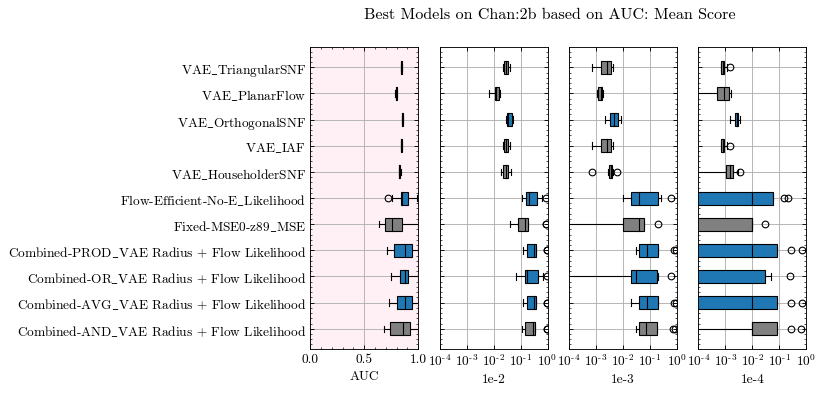

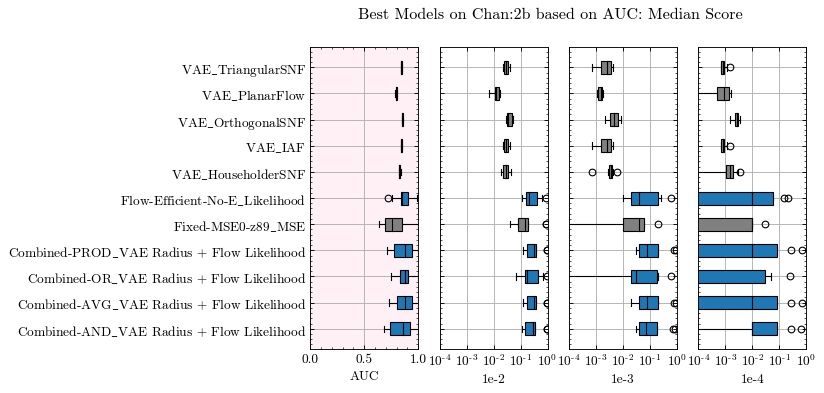

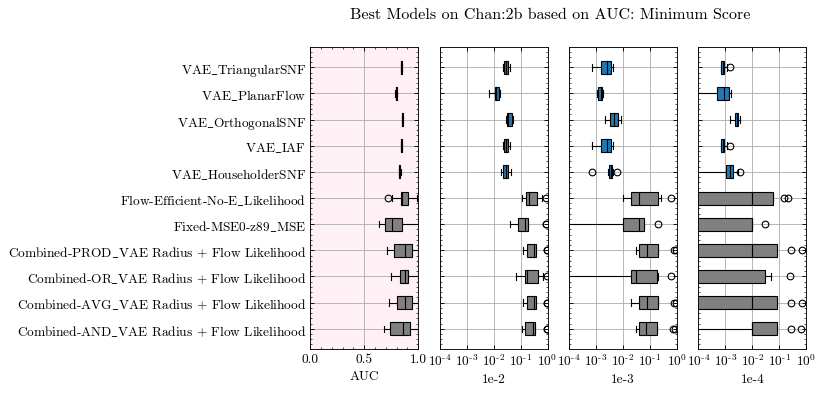

In [25]:
Analyze(AllCombined, 
        Chan='2b', 
        Metric='AUC',
        MetricNumberDict = {'top1': 5,
                            'top5': 8,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )

### 1e-2

****************************************
Models from chan=2b ranked by metric=1e-2 sorted by top1
                                          Model  top1
476  Combined-PROD_VAE Radius + Flow Likelihood     3
177                           OR_30_0.001_10000     2
477   Combined-AVG_VAE Radius + Flow Likelihood     2
10                               IF_20_0.1_1000     1
475    Combined-OR_VAE Radius + Flow Likelihood     1
****************************************

****************************************
Models from chan=2b ranked by metric=1e-2 sorted by top5
                                          Model  top5
474   Combined-AND_VAE Radius + Flow Likelihood     5
477   Combined-AVG_VAE Radius + Flow Likelihood     5
476  Combined-PROD_VAE Radius + Flow Likelihood     5
471                   Flow-Efficient_Likelihood     5
472              Flow-Efficient-No-E_Likelihood     4
104                        KMeans_20_0.001_1000     3
****************************************

******************

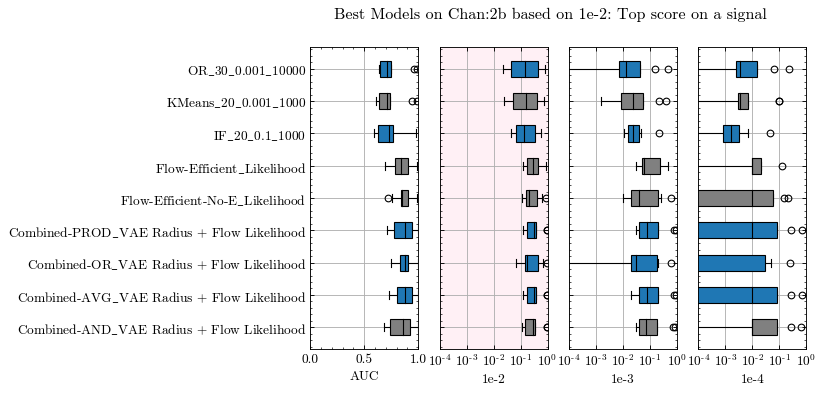

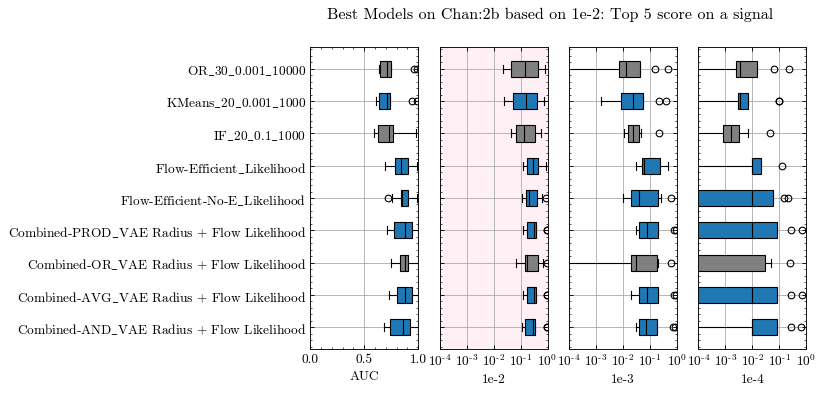

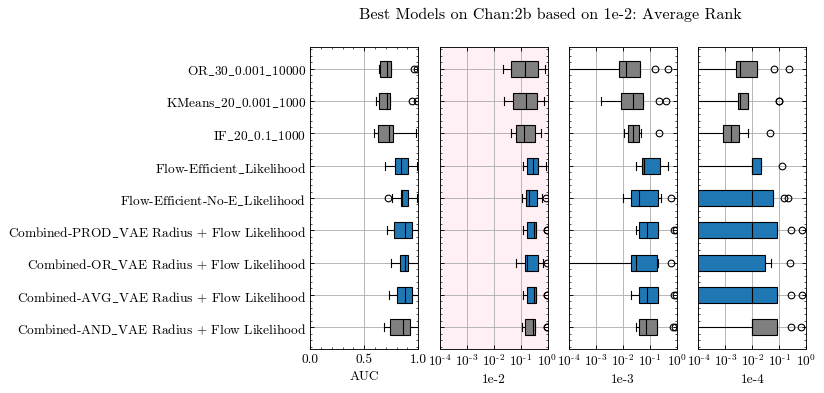

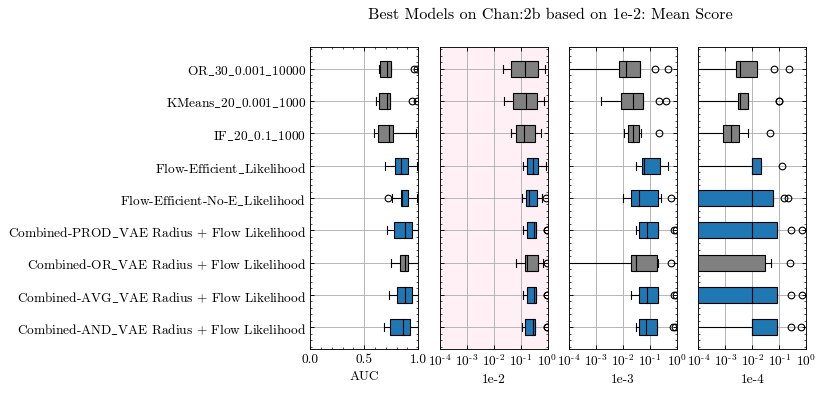

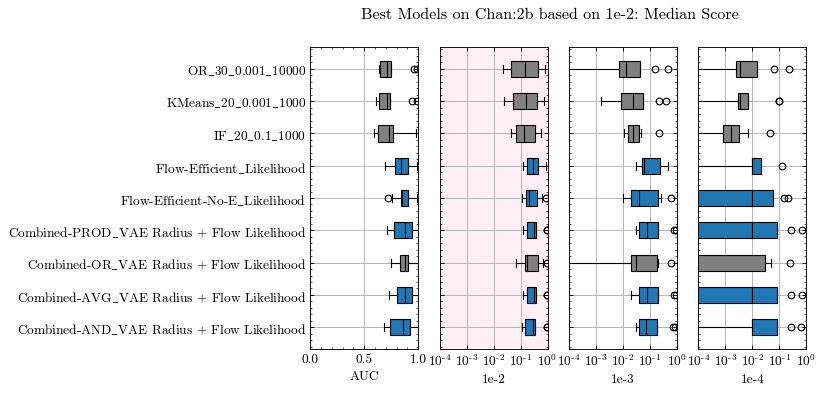

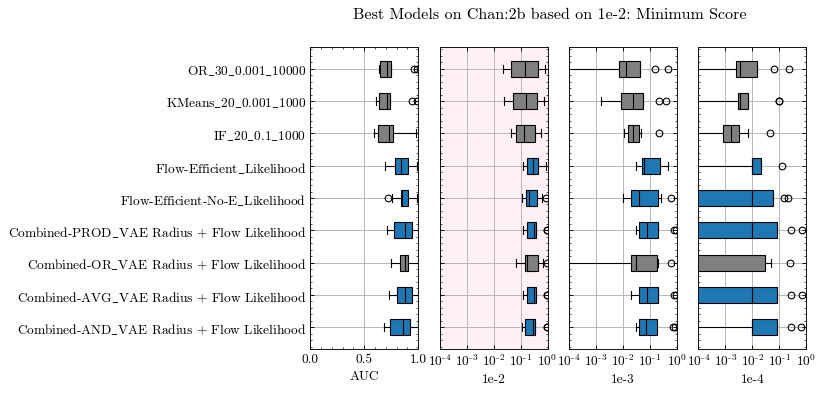

In [26]:
Analyze(AllCombined, 
        Chan='2b', 
        Metric='1e-2',
        MetricNumberDict = {'top1': 5,
                            'top5': 6,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )

### 1e-3

****************************************
Models from chan=2b ranked by metric=1e-3 sorted by top1
                                          Model  top1
477   Combined-AVG_VAE Radius + Flow Likelihood     3
559             DeepSetVAE_beta_1.0_weight_10.0     2
341                VAE-dynamic-beta1e-06-z13_RL     2
353                 VAE-dynamic-beta0.001-z5_RL     1
476  Combined-PROD_VAE Radius + Flow Likelihood     1
****************************************

****************************************
Models from chan=2b ranked by metric=1e-3 sorted by top5
                                          Model  top5
474   Combined-AND_VAE Radius + Flow Likelihood     5
476  Combined-PROD_VAE Radius + Flow Likelihood     5
559             DeepSetVAE_beta_1.0_weight_10.0     4
477   Combined-AVG_VAE Radius + Flow Likelihood     4
341                VAE-dynamic-beta1e-06-z13_RL     3
****************************************

****************************************
Models from chan=2b ranked by m

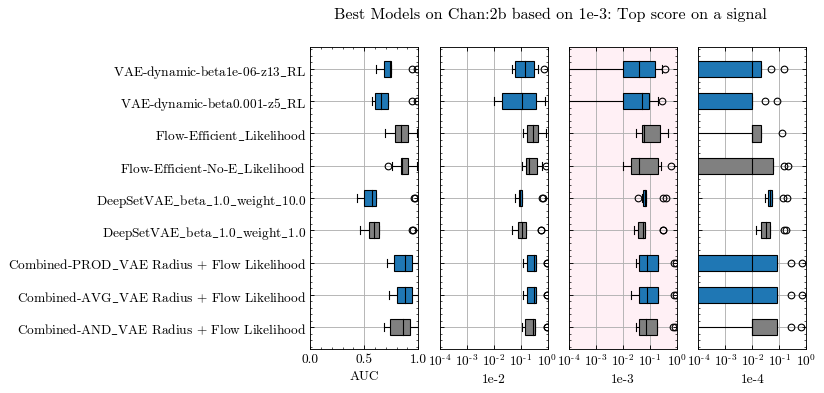

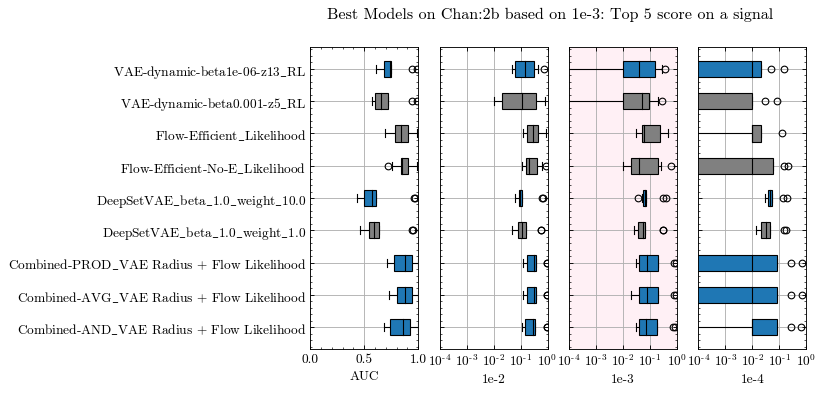

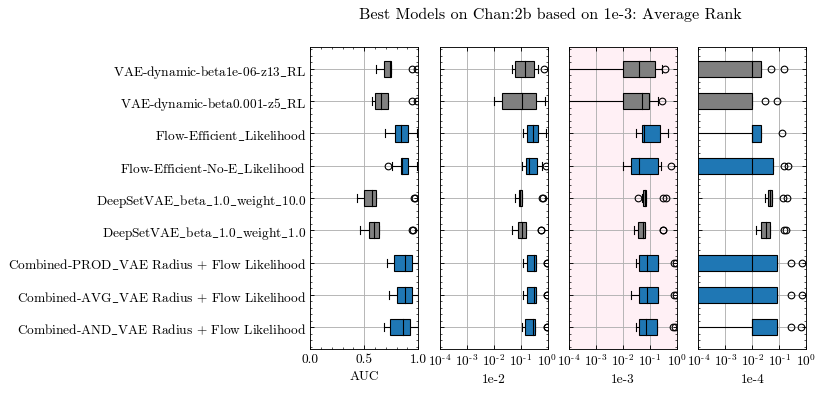

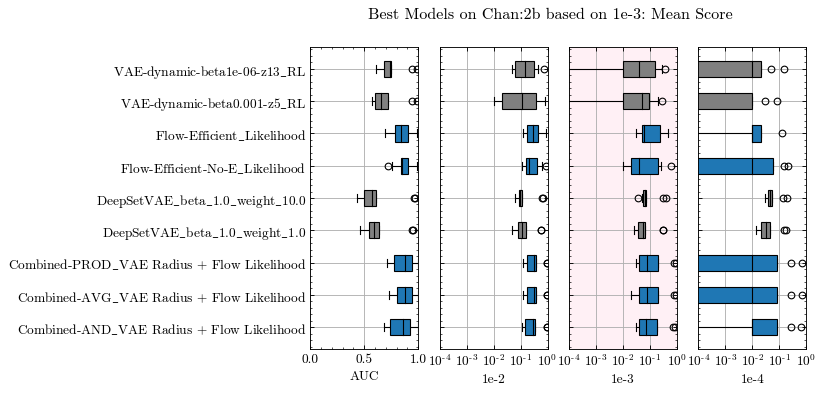

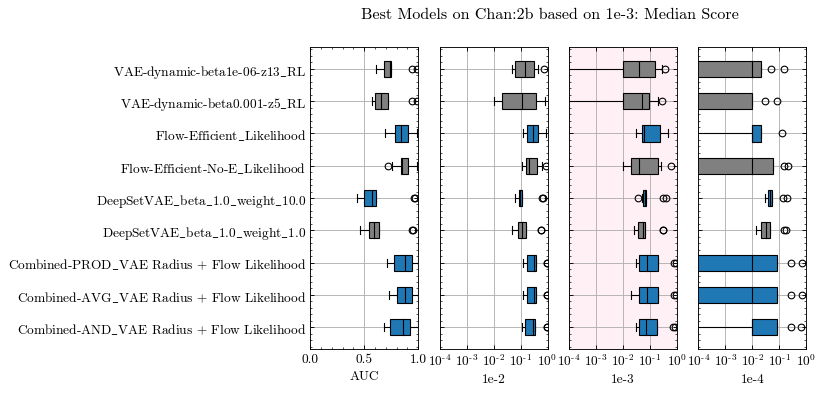

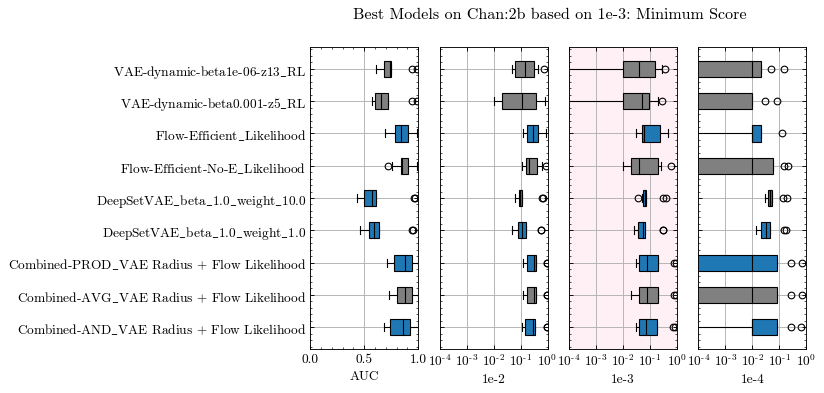

In [27]:
Analyze(AllCombined, 
        Chan='2b', 
        Metric='1e-3',
        MetricNumberDict = {'top1': 5,
                            'top5': 5,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )

### 1e-4

****************************************
Models from chan=2b ranked by metric=1e-4 sorted by top1
                                         Model  top1
559            DeepSetVAE_beta_1.0_weight_10.0     6
299                                    PCA_D=6     1
477  Combined-AVG_VAE Radius + Flow Likelihood     1
341               VAE-dynamic-beta1e-06-z13_RL     1
****************************************

****************************************
Models from chan=2b ranked by metric=1e-4 sorted by top5
                               Model  top5
559  DeepSetVAE_beta_1.0_weight_10.0     6
558   DeepSetVAE_beta_1.0_weight_1.0     5
****************************************

****************************************
Models from chan=2b ranked by metric=1e-4 sorted by AverageRank
                               Model  AverageRank
158                 VAE_4_1e-05_1000    13.666667
190                  OR_4_1e-05_1000    16.111111
559  DeepSetVAE_beta_1.0_weight_10.0    29.777778
174                 O

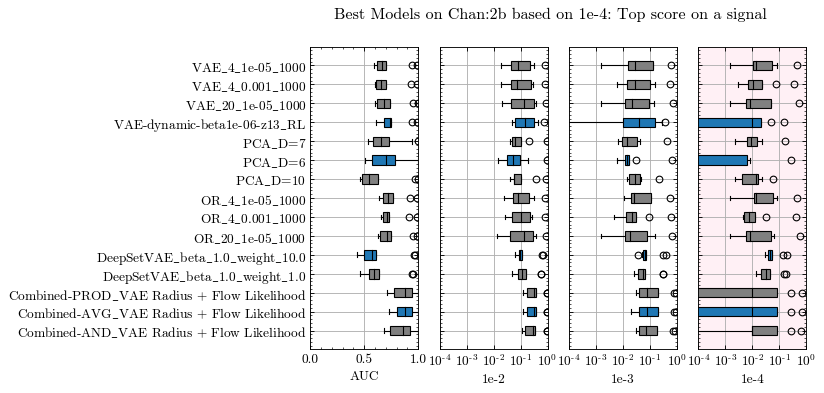

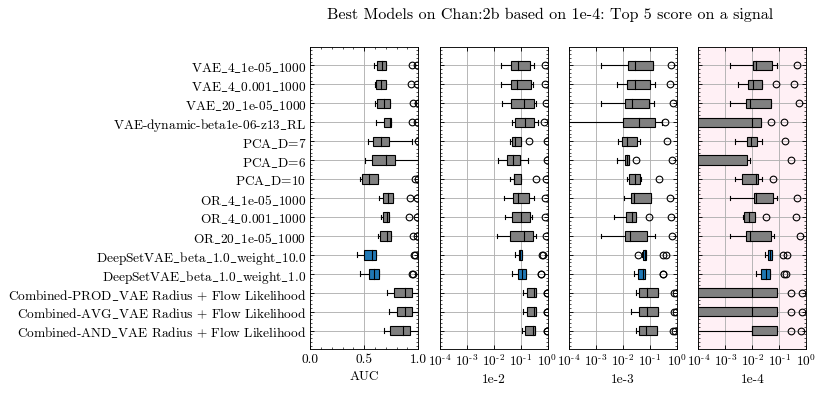

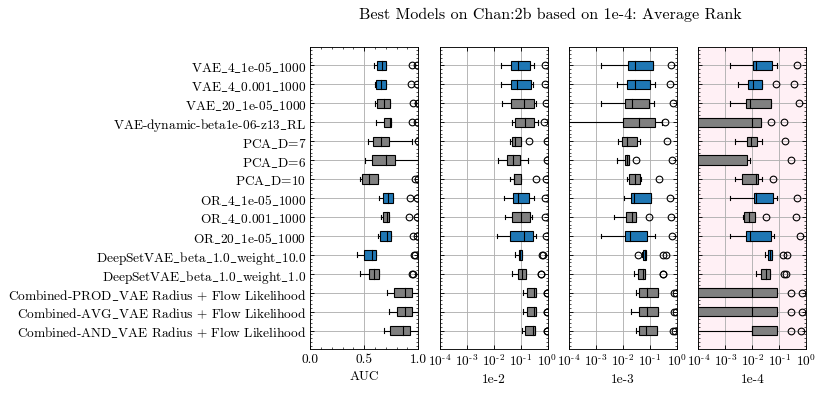

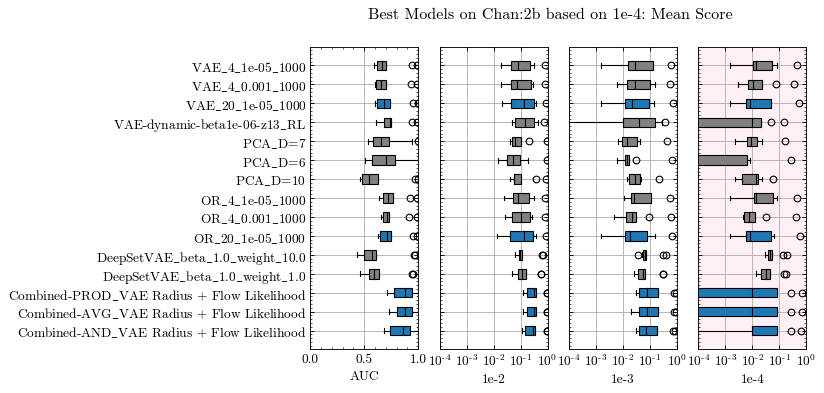

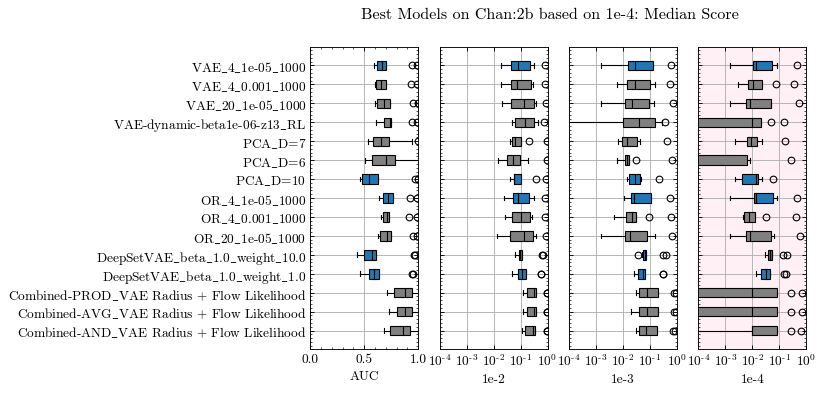

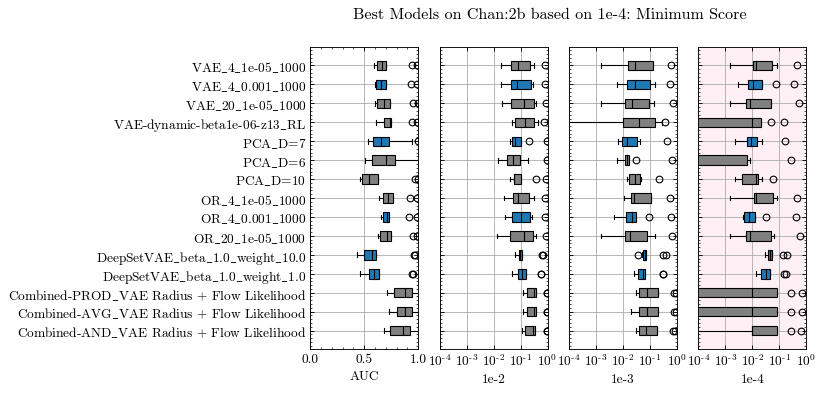

In [28]:
Analyze(AllCombined, 
        Chan='2b', 
        Metric='1e-4',
        MetricNumberDict = {'top1': 4,
                            'top5': 2,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )

## Chan 3
### AUC

****************************************
Models from chan=3 ranked by metric=AUC sorted by top1
                  Model  top1
290  VAE_HouseholderSNF     6
****************************************

****************************************
Models from chan=3 ranked by metric=AUC sorted by top5
                                          Model  top5
290                          VAE_HouseholderSNF     8
289                              VAE_PlanarFlow     7
292                           VAE_TriangularSNF     6
477   Combined-AVG_VAE Radius + Flow Likelihood     5
291                           VAE_OrthogonalSNF     4
476  Combined-PROD_VAE Radius + Flow Likelihood     3
473             Flow-Only-Aggregates_Likelihood     3
****************************************

****************************************
Models from chan=3 ranked by metric=AUC sorted by AverageRank
                                          Model  AverageRank
477   Combined-AVG_VAE Radius + Flow Likelihood         10.7
476  Co

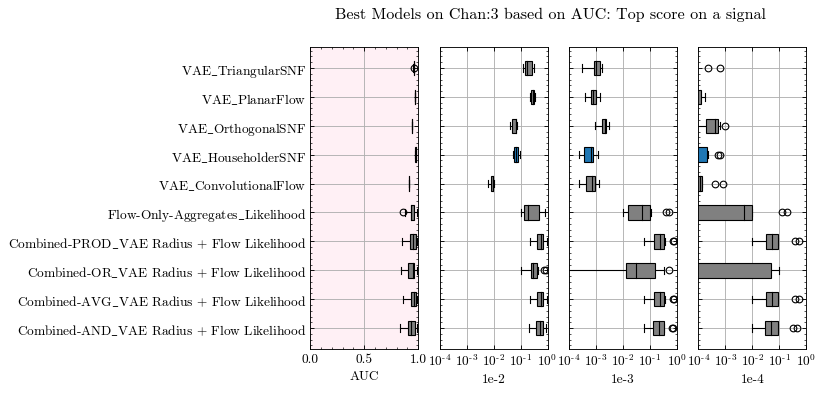

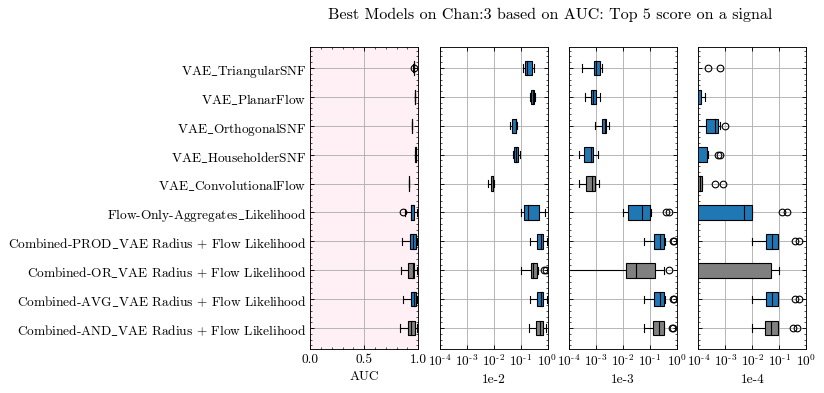

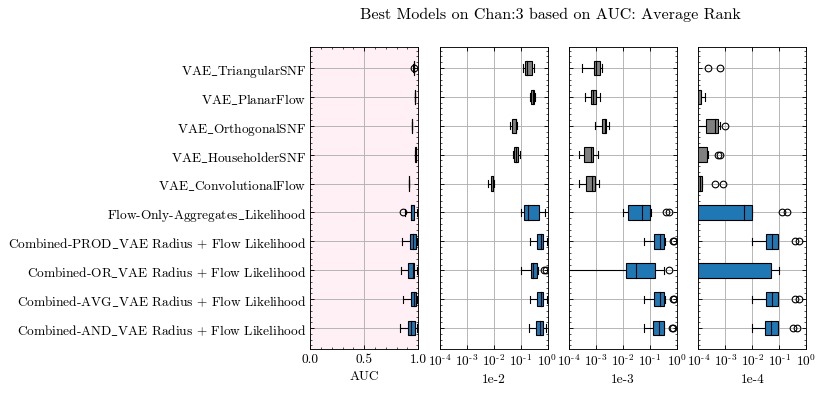

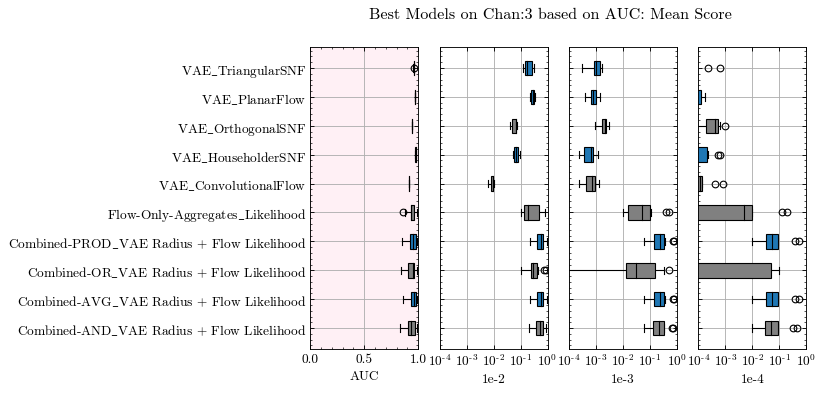

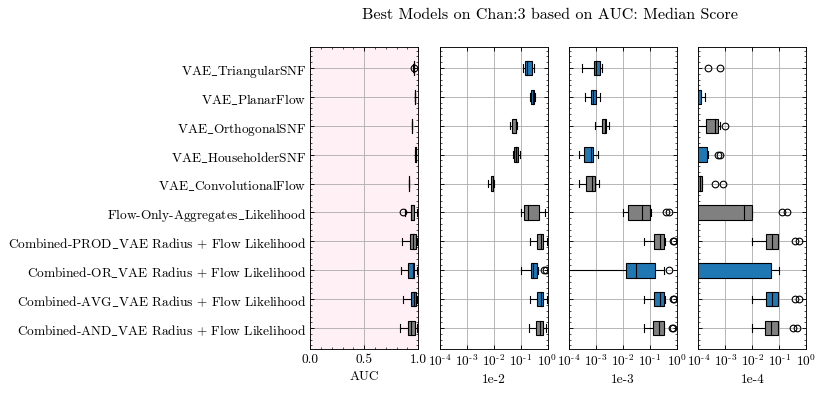

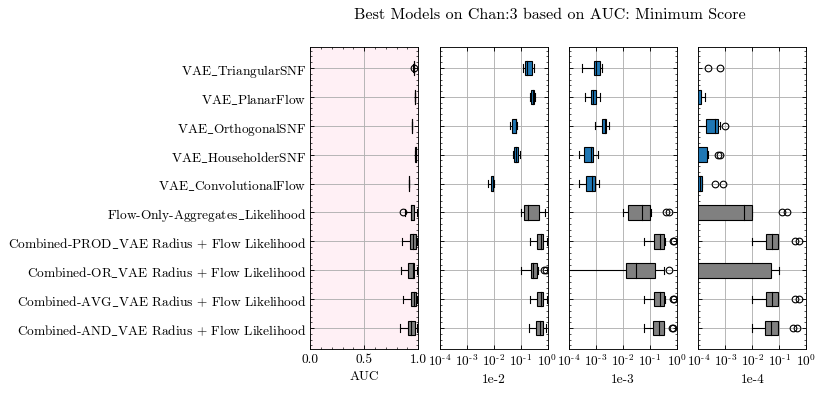

In [29]:
Analyze(AllCombined, 
        Chan='3', 
        Metric='AUC',
        MetricNumberDict = {'top1': 1,
                            'top5': 7,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )

### 1e-2

****************************************
Models from chan=3 ranked by metric=1e-2 sorted by top1
                                          Model  top1
477   Combined-AVG_VAE Radius + Flow Likelihood     5
476  Combined-PROD_VAE Radius + Flow Likelihood     4
289                              VAE_PlanarFlow     1
****************************************

****************************************
Models from chan=3 ranked by metric=1e-2 sorted by top5
                                          Model  top5
474   Combined-AND_VAE Radius + Flow Likelihood    10
477   Combined-AVG_VAE Radius + Flow Likelihood    10
476  Combined-PROD_VAE Radius + Flow Likelihood    10
****************************************

****************************************
Models from chan=3 ranked by metric=1e-2 sorted by AverageRank
                                          Model  AverageRank
477   Combined-AVG_VAE Radius + Flow Likelihood          0.6
476  Combined-PROD_VAE Radius + Flow Likelihood          0.6
474

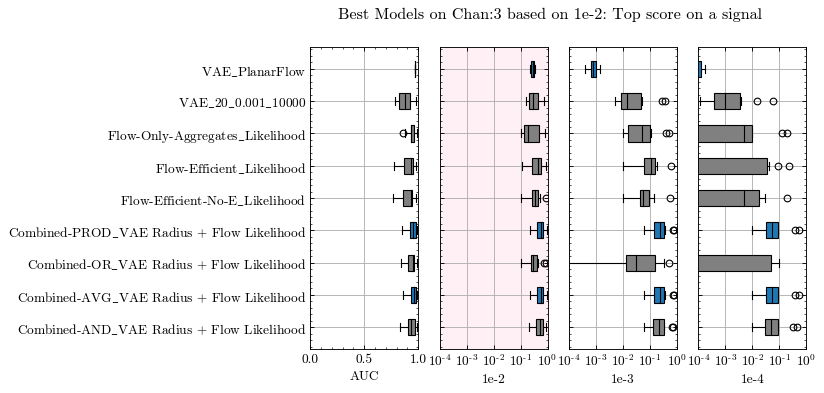

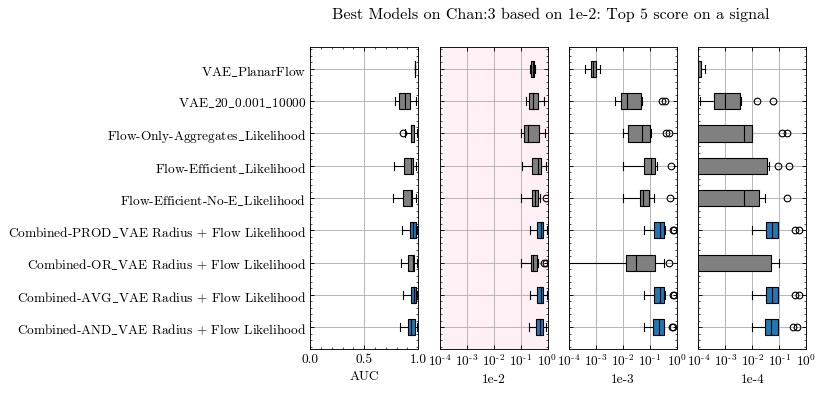

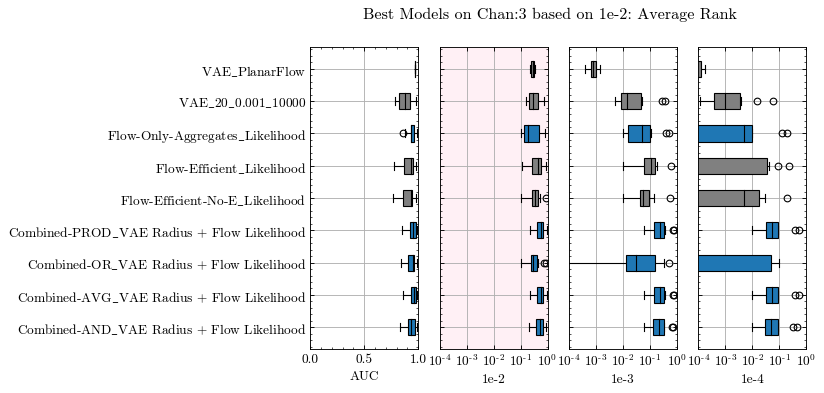

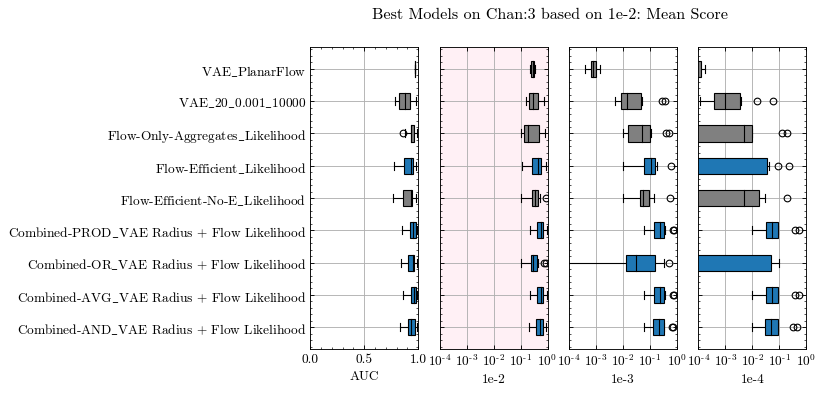

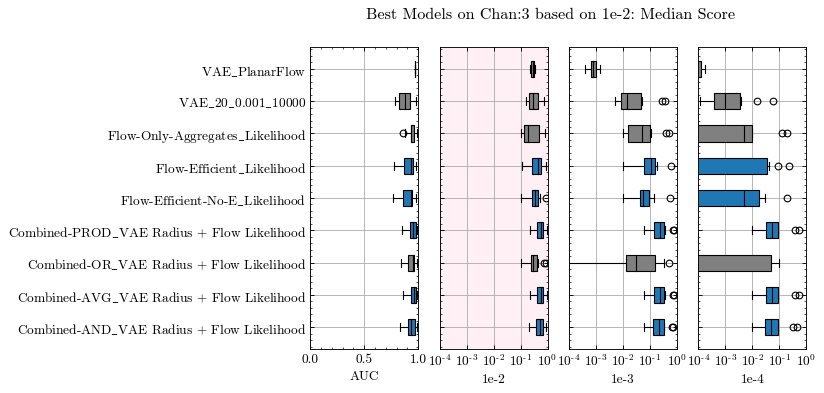

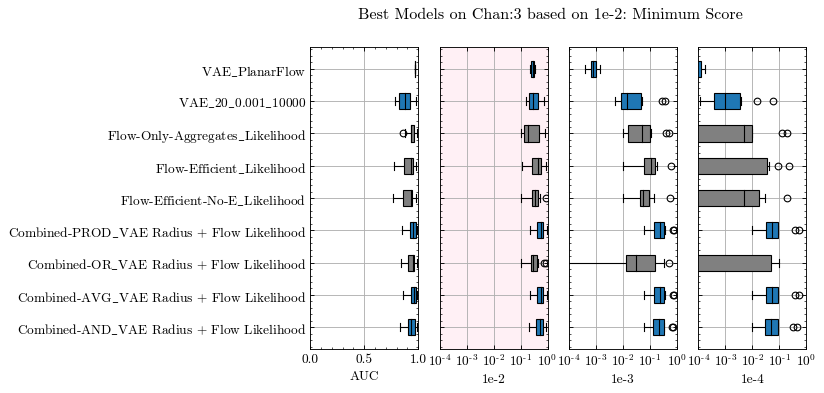

In [30]:
Analyze(AllCombined, 
        Chan='3', 
        Metric='1e-2',
        MetricNumberDict = {'top1': 3,
                            'top5': 3,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )

### 1e-3

****************************************
Models from chan=3 ranked by metric=1e-3 sorted by top1
                                          Model  top1
477   Combined-AVG_VAE Radius + Flow Likelihood     6
476  Combined-PROD_VAE Radius + Flow Likelihood     4
****************************************

****************************************
Models from chan=3 ranked by metric=1e-3 sorted by top5
                                          Model  top5
477   Combined-AVG_VAE Radius + Flow Likelihood    10
476  Combined-PROD_VAE Radius + Flow Likelihood    10
474   Combined-AND_VAE Radius + Flow Likelihood    10
****************************************

****************************************
Models from chan=3 ranked by metric=1e-3 sorted by AverageRank
                                          Model  AverageRank
477   Combined-AVG_VAE Radius + Flow Likelihood          0.4
476  Combined-PROD_VAE Radius + Flow Likelihood          0.6
474   Combined-AND_VAE Radius + Flow Likelihood          

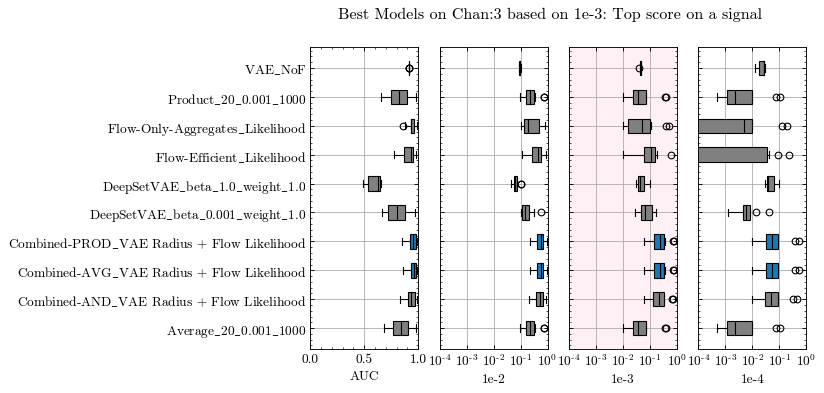

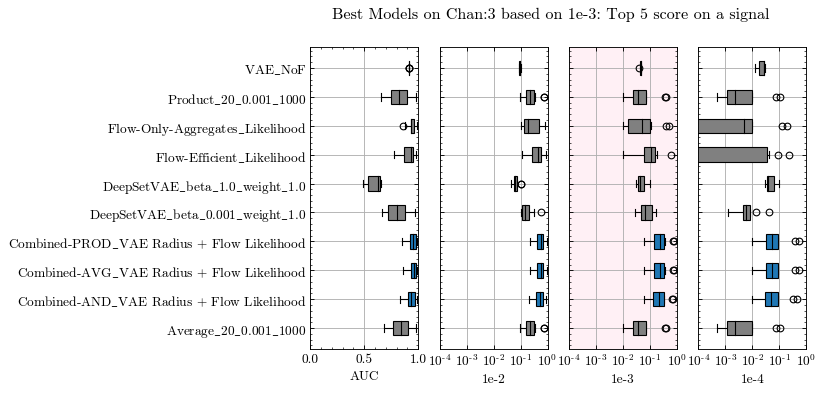

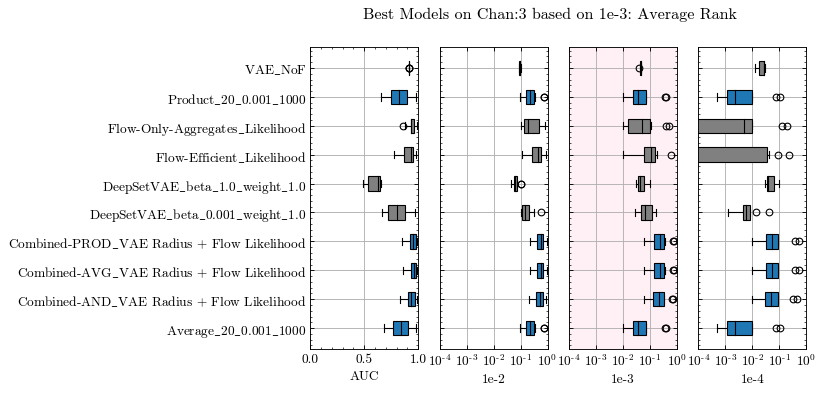

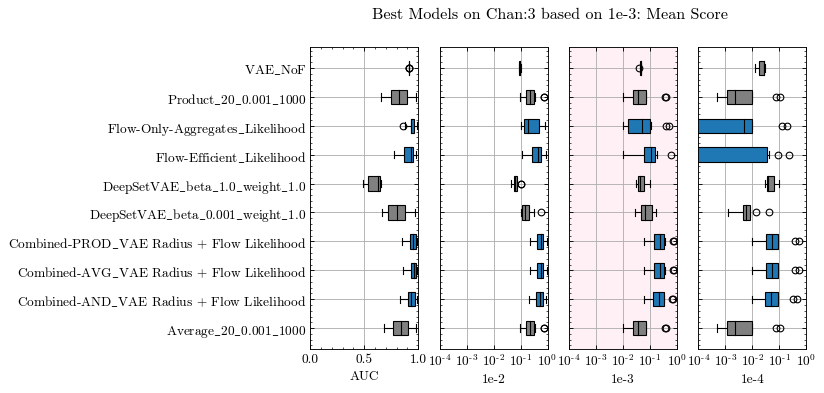

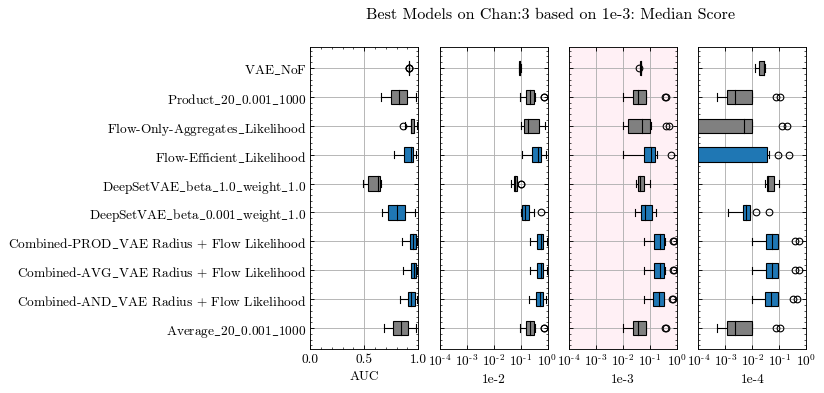

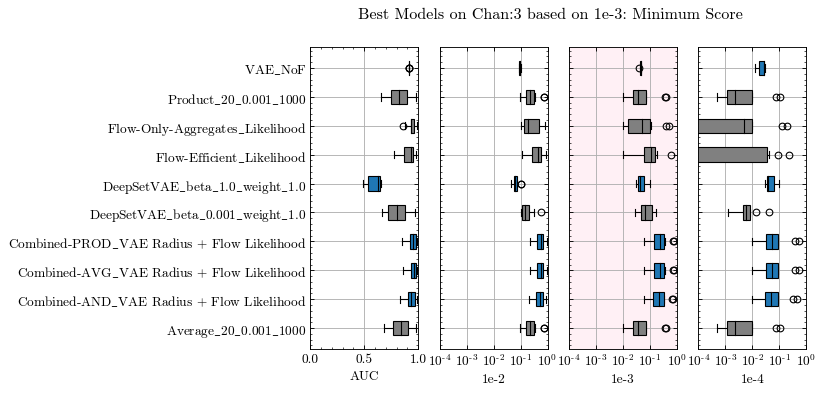

In [31]:
Analyze(AllCombined, 
        Chan='3', 
        Metric='1e-3',
        MetricNumberDict = {'top1': 2,
                            'top5': 3,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )

### 1e-4

****************************************
Models from chan=3 ranked by metric=1e-4 sorted by top1
                                          Model  top1
550              DeepSetVAE_beta_1.0_weight_1.0     5
476  Combined-PROD_VAE Radius + Flow Likelihood     3
301                                     PCA_D=8     1
477   Combined-AVG_VAE Radius + Flow Likelihood     1
****************************************

****************************************
Models from chan=3 ranked by metric=1e-4 sorted by top5
                                          Model  top5
476  Combined-PROD_VAE Radius + Flow Likelihood     8
477   Combined-AVG_VAE Radius + Flow Likelihood     7
550              DeepSetVAE_beta_1.0_weight_1.0     7
474   Combined-AND_VAE Radius + Flow Likelihood     6
288                                     VAE_NoF     5
****************************************

****************************************
Models from chan=3 ranked by metric=1e-4 sorted by AverageRank
                        

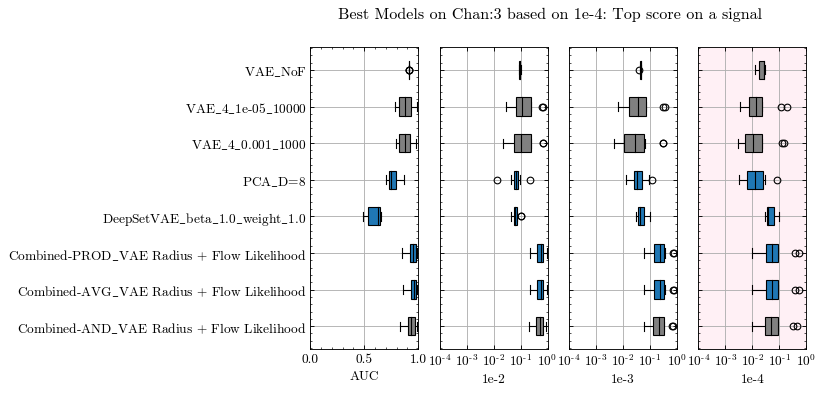

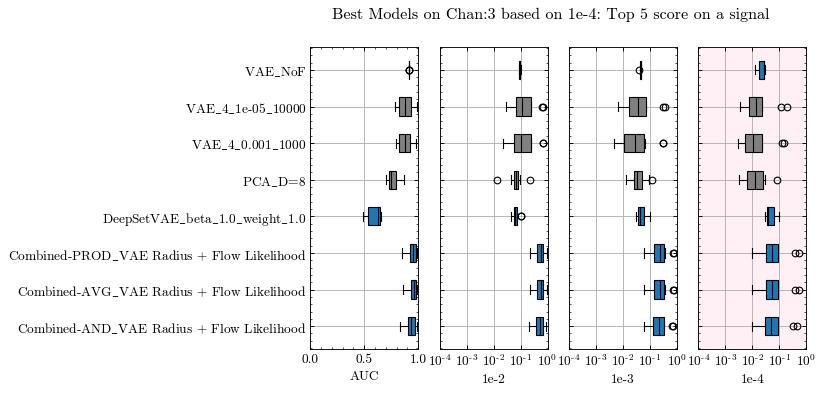

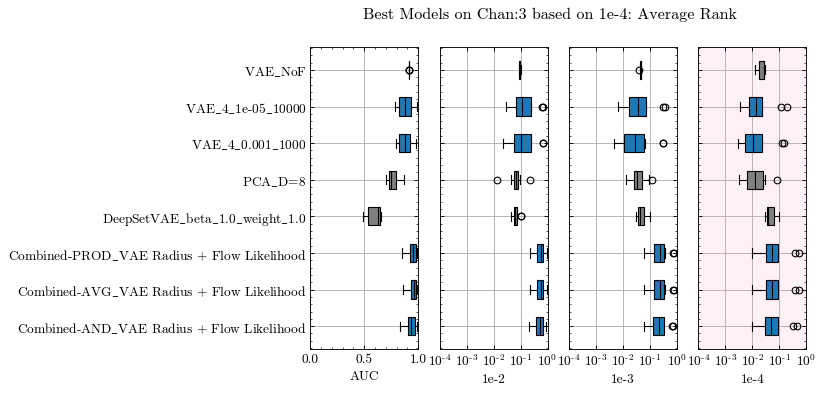

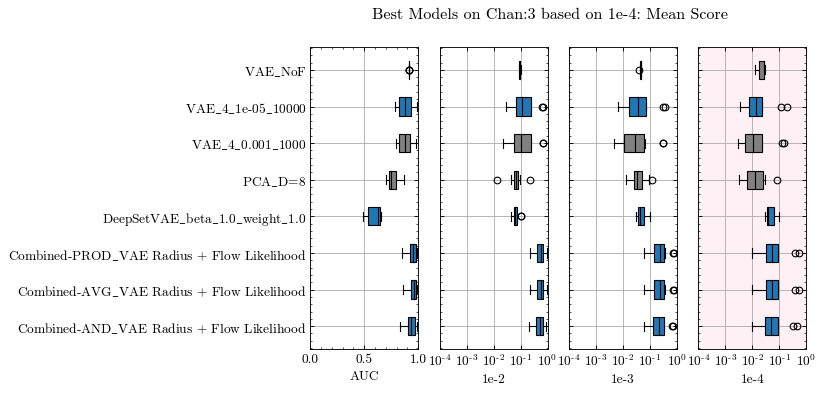

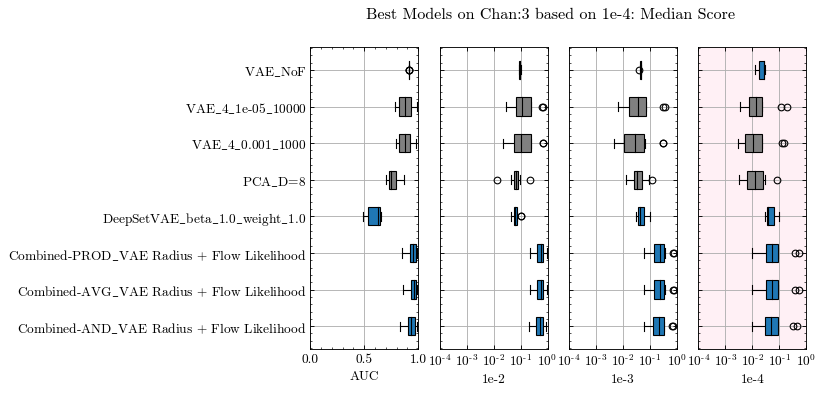

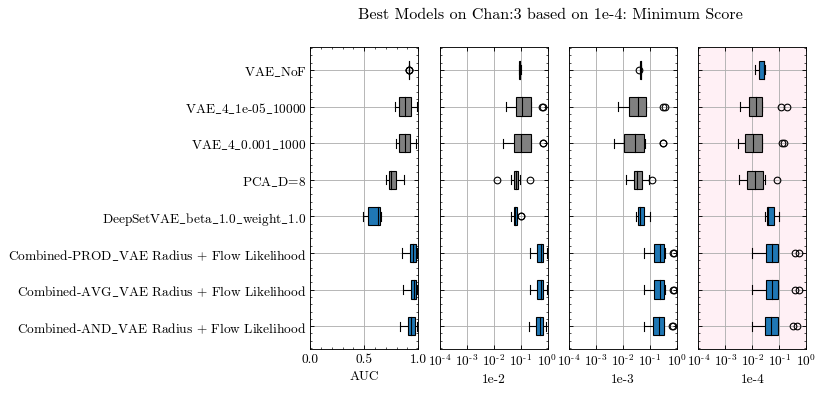

In [32]:
Analyze(AllCombined, 
        Chan='3', 
        Metric='1e-4',
        MetricNumberDict = {'top1': 4,
                            'top5': 5,
                            'AverageRank': 5,
                            'MeanScore': 5,
                            'MedianScore': 5,
                            'MinScore': 5},
        Plot=True
       )